In [1]:
import os
seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
experiment = '20 days CNN Images Experiments - noncyclic'

In [2]:
import requests
import lxml
import datetime as dt
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.utils import compute_class_weight
import tensorflow as tf
from pil import Image
from sklearn import preprocessing
import tensorflow_addons as tfa
import glob
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
import math

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
# gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.333)
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
np.random.seed(seed)
tf.random.set_seed(seed)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

## Performance Metrics Functions

In [5]:
def pred_acc(actual, predictions, logger):

    hold = 0
    sell = 0
    buy = 0
    pred_hold = 0
    pred_sell = 0
    pred_buy = 0
    buy_buy = 0
    buy_sell = 0
    buy_hold = 0
    sell_buy = 0
    sell_sell = 0
    sell_hold = 0
    hold_buy = 0
    hold_sell = 0
    hold_hold = 0

    for i in range (0,len(actual)):
        if actual[i]==1 and predictions[i] == 1:
            buy_buy += 1
            buy += 1
            pred_buy += 1
        elif actual[i]==1 and predictions[i] == 0:
            buy_sell += 1
            buy += 1
            pred_sell += 1
        elif actual[i]==1 and predictions[i] == 2:
            buy_hold += 1
            buy += 1
            pred_hold += 1
        elif actual[i]==0 and predictions[i] == 1:
            sell_buy += 1
            sell += 1
            pred_buy += 1
        elif actual[i]==0 and predictions[i] == 0:
            sell_sell += 1
            sell += 1
            pred_sell += 1
        elif actual[i]==0 and predictions[i] == 2:
            sell_hold += 1
            sell += 1
            pred_hold += 1
        elif actual[i]==2 and predictions[i] == 1:
            hold_buy += 1
            hold += 1
            pred_buy += 1
        elif actual[i]==2 and predictions[i] == 0:
            hold_sell += 1
            hold += 1
            pred_sell += 1
        elif actual[i]==2 and predictions[i] == 2:
            hold_hold += 1
            hold += 1
            pred_hold += 1

    print("number of predictions: " + str(len(actual)))
    print("actual predicted buys: " + str(buy_buy) )
    print("actual buys but predicted sell: " + str(buy_sell) )
    print("actual buys but predicted hold: " + str(buy_hold))
    print("actual sells but predicted buy: " + str(sell_buy) )
    print("actual predicted sells: " + str(sell_sell))
    print("actual sells but predicted hold: " + str(sell_hold) )
    print("actual holds but predicted buy: " + str(hold_buy) )
    print("actual holds but predicted sell: " + str(hold_sell))
    print("actual predicted holds: " + str(hold_hold) )
    
    if pred_buy !=0:
        Percentage_buys_correct = 100*buy_buy/pred_buy
    else:
        Percentage_buys_correct = 0
        
    if pred_sell !=0:
        Percentage_sells_correct = 100*sell_sell/pred_sell
    else:
        Percentage_sells_correct = 0
        
    if pred_hold !=0:
        Percentage_holds_correct = 100*hold_hold/pred_hold
    else:
        Percentage_holds_correct = 0

    print("Percentage buys correct: " + str(Percentage_buys_correct) + "%")
    print("Percentage sells correct: " + str(Percentage_sells_correct) + "%")
    print("Percentage holds correct: " + str(Percentage_holds_correct) + "%")

    print("actual buys: " + str(buy))
    print("actual sells: " + str(sell))
    print("actual holds: " + str(hold))
    logger.append(Percentage_buys_correct) ; logger.append(Percentage_sells_correct) ; logger.append(Percentage_holds_correct)
    
    return logger


In [6]:
def correct_maxima_minima(predictions, price, logger):
    correct_maxima = 0 
    correct_minima = 0
    correct_hold = 0

    hold = 0
    buy = 0
    sell = 0

#     predictions = df['predictions'].values.tolist()
#     price = df['previous_1d'].values.tolist()

    for i in range(0,len(predictions)):
        if i < 4:
            prices = price[i:i+9]
            prices.sort(key = float)
#             if i == 0:
#                 print(prices)
            highest_1 = prices[-1]
            highest_2 = prices[-2]
            highest_3 = prices[-3]
            highest_4 = prices[-4]
            lowest_1 = prices[0]
            lowest_2 = prices[1]
            lowest_3 = prices[2]
            lowest_4 = prices[3]
            if predictions[i] == 0:
                sell += 1
                if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                    correct_maxima += 1
            elif predictions[i] == 1:
                buy += 1
                if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                    correct_minima += 1
            elif predictions[i] == 2:
                hold += 1
                if price[i] != lowest_1 and price[i] != highest_1:
                    correct_hold += 1

        else:
            prices = price[i:i+5]
            prices = prices + price[i-4:i] 
            prices.sort(key = float)
#             if i == 10:
#                 print(prices)
            highest_1 = prices[-1]
            highest_2 = prices[-2]
            highest_3 = prices[-3]
            highest_4 = prices[-4]
            lowest_1 = prices[0]
            lowest_2 = prices[1]
            lowest_3 = prices[2]
            lowest_4 = prices[3]
            if predictions[i] == 0:
                sell += 1
                if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                    correct_maxima += 1
            elif predictions[i] == 1:
                buy += 1
                if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                    correct_minima += 1
            elif predictions[i] == 2:
                hold += 1
                if price[i] != lowest_1 and price[i] != highest_1:
                    correct_hold += 1
                    
    if buy !=0:
        Percentage_buys_correct = 100*correct_minima/buy
    else:
        Percentage_buys_correct = 0
        
    if sell !=0:
        Percentage_sells_correct = 100*correct_maxima/sell
    else:
        Percentage_sells_correct = 0
        
    if hold !=0:
        Percentage_holds_correct = 100*correct_hold/hold
    else:
        Percentage_holds_correct = 0

    print("Percentage low buys correct: " + str(Percentage_buys_correct) + "%")
    print("Percentage high sells correct: " + str(Percentage_sells_correct) + "%")
    print("Percentage mid holds correct: " + str(Percentage_holds_correct) + "%")
    logger.append(Percentage_buys_correct) ; logger.append(Percentage_sells_correct) ; logger.append(Percentage_holds_correct)
    
    return logger

In [7]:
def profit(predictions, price, logger):
    
    price = np.array([price]).reshape(-1, 1)
    min_max_scaler = preprocessing.MinMaxScaler()
    price = min_max_scaler.fit_transform(price)
    price = price.flatten().tolist()
    price = [x + 0.01 for x in price]
    
#     avg_price = sum(price) / len(price)
#     avg_price = int(avg_price)
#     print("Avg price of stocks: " + str(avg_price))
    
#     tens = 1
#     while avg_price >= 10:
#         avg_price /= 10
#         tens += 1
    
    
#     capital = 100*pow(10,tens-1)
    capital = 100
    print("Capital: " + str(capital))
    shares = 0

    previously_buy = False
    previously_sell = False
    prev_buy_price = 0
    bought_once = False


#     predictions = df['predictions'].values.tolist()
#     price = df['previous_1d'].values.tolist()

    for i in range(0,len(predictions)):

#         if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 5 and shares!=0:
#             capital += 0.99725 * (shares*price[i])
#             shares = 0
#             print("Stop Loss Activated!\n")
#             print("Share price: $" + str(price[i]))
#             print("Shares owned at the moment: " + str(shares))
#             print("Cash capital at the moment: $" + str(capital))
#             print("\n")
#             previously_buy = False
#             previously_sell = True

        if predictions[i] == 1 and previously_buy != True:
            shares = math.floor(capital / (price[i]*1.00275))
            capital = capital - shares*price[i]*1.00275
            print("Share price: $" + str(price[i]))
            print("Shares owned at the moment: " + str(shares))
            print("Cash capital at the moment: $" + str(capital))
            print("\n")
            prev_buy_price = price[i]*1.00275
            bought_once = True
            previously_buy = True
            previously_sell = False

        elif predictions[i] == 0 and previously_sell != True and shares!=0: #and (price[i]/prev_buy_price-1)*100 >= 2
            capital += 0.99725 * (shares*price[i])
            shares = 0
            print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
            print("Share price: $" + str(price[i]))
            print("Shares owned at the moment: " + str(shares))
            print("Cash capital at the moment: $" + str(capital))
            print("\n")
            previously_buy = False
            previously_sell = True

    if shares!=0:
        capital += 0.99725 * (shares*price[i])

    print('\n')
    print("Capital at the end of test period: $" +str(capital))
    print("profit gained: " + str(((capital- 100 )/ 100) * 100 ) + '%') 
    logger.append(((capital- 100 )/ 100) * 100)
    
    capital = 100
    shares = 0

    shares = math.floor(capital / (price[0]*1.00275))
    capital = capital - shares*price[0]*1.00275
    capital += 0.99725 * (shares*price[-1])

    print('\n')
    print("Capital at the end of test period if Buy and Hold: $" +str(capital))
    print("profit gained: " + str(((capital- 100 )/ 100) * 100 ) + '%') 
    logger.append(((capital- 100 )/ 100) * 100 )
    
    return logger

## noncyclic Stocks

### Kweichow Moutai Co.,Ltd.

In [70]:
nr_test_sets = ['600519.SS']
nr_test_data = {}

for name in nr_test_sets:

    df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test.csv".format(name))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data.csv".format(name))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-5:]
    df2 = pd.concat([df2,df])
    df = df2
    print(df.head())
    
    willr_data = []
    price_data = []
    ema_data = []
    obv_data = []
    labels = []
    data_20_price = []
    data_20_willr = []
    data_20_ema = []
    data_20_obv = []
    count = 0

    for i in df.values:
        if count == 19:
            data_20_price.append([i[0]])
            data_20_ema.append([i[1]])
            data_20_willr.append([i[2]])
            data_20_obv.append([i[3]])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_20_price_arr = min_max_scaler.fit_transform(data_20_price)
            data_20_ema_arr = min_max_scaler.fit_transform(data_20_ema)
            data_20_willr_arr = min_max_scaler.fit_transform(data_20_willr)
            data_20_obv_arr = min_max_scaler.fit_transform(data_20_obv)
            price_data.append(data_20_price_arr)
            willr_data.append(data_20_willr_arr)
            ema_data.append(data_20_ema_arr)
            obv_data.append(data_20_obv_arr)
            labels.append(i[-1])
            data_20_price = data_20_price[1:]
            data_20_willr = data_20_willr[1:]
            data_20_obv = data_20_obv[1:]
            data_20_ema = data_20_ema[1:]

        else:
            data_20_price.append([i[0]])
            data_20_ema.append([i[1]])
            data_20_willr.append([i[2]])
            data_20_obv.append([i[3]])
            count += 1

    willr_data = np.array(willr_data)
    price_data = np.array(price_data)
    ema_data = np.array(ema_data)
    obv_data = np.array(obv_data)
    
    sequential_data = []
    
    for i in range(0,len(willr_data)):
        j = willr_data[i]
        k = price_data[i]
        l = ema_data[i]
        m = obv_data[i]
        fig, ax = plt.subplots()
        fig.set_size_inches((5,5))

        ax.plot(k)
        ax.plot(j)
        ax.plot(l)
        ax.plot(m)

        ax.axis('off')

        fig.add_axes(ax)
        fig.canvas.draw()

        # this rasterized the figure
        X = np.array(fig.canvas.renderer._renderer)
        X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
        X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
        sequential_data.append(X)
        plt.close()
        
    X = sequential_data
    y = labels

    X  = np.array(X).reshape(-1, 64, 64, 1)
    X = X/255
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    nr_test_data['{}_X'.format(name)] = X
    nr_test_data['{}_y'.format(name)] = y

            previous_1d      EMA_12   willr_14         OBV_7  labels
Date                                                                
2018-12-13   589.000000  582.108121 -38.732394  1.228418e+09     2.0
2018-12-14   601.750000  585.129949 -20.774648  1.232458e+09     2.0
2018-12-17   592.960022  586.334575 -33.154899  1.230002e+09     2.0
2018-12-18   590.520020  586.978490 -36.591522  1.227513e+09     2.0
2018-12-19   590.940002  587.587953 -37.872279  1.229435e+09     2.0


In [71]:
r_test_sets = ['600519.SS']
r_test_data = {}

for name in r_test_sets:

    df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test2.csv".format(name))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test.csv".format(name))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-5:]
    df2 = pd.concat([df2,df])
    df = df2
    print(df.head())
    
    willr_data = []
    price_data = []
    ema_data = []
    obv_data = []
    labels = []
    data_20_price = []
    data_20_willr = []
    data_20_ema = []
    data_20_obv = []
    count = 0

    for i in df.values:
        if count == 19:
            data_20_price.append([i[0]])
            data_20_ema.append([i[1]])
            data_20_willr.append([i[2]])
            data_20_obv.append([i[3]])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_20_price_arr = min_max_scaler.fit_transform(data_20_price)
            data_20_ema_arr = min_max_scaler.fit_transform(data_20_ema)
            data_20_willr_arr = min_max_scaler.fit_transform(data_20_willr)
            data_20_obv_arr = min_max_scaler.fit_transform(data_20_obv)
            price_data.append(data_20_price_arr)
            willr_data.append(data_20_willr_arr)
            ema_data.append(data_20_ema_arr)
            obv_data.append(data_20_obv_arr)
            labels.append(i[-1])
            data_20_price = data_20_price[1:]
            data_20_willr = data_20_willr[1:]
            data_20_obv = data_20_obv[1:]
            data_20_ema = data_20_ema[1:]

        else:
            data_20_price.append([i[0]])
            data_20_ema.append([i[1]])
            data_20_willr.append([i[2]])
            data_20_obv.append([i[3]])
            count += 1

    willr_data = np.array(willr_data)
    price_data = np.array(price_data)
    ema_data = np.array(ema_data)
    obv_data = np.array(obv_data)
    
    sequential_data = []
    
    for i in range(0,len(willr_data)):
        j = willr_data[i]
        k = price_data[i]
        l = ema_data[i]
        m = obv_data[i]
        fig, ax = plt.subplots()
        fig.set_size_inches((5,5))

        ax.plot(k)
        ax.plot(j)
        ax.plot(l)
        ax.plot(m)

        ax.axis('off')

        fig.add_axes(ax)
        fig.canvas.draw()

        # this rasterized the figure
        X = np.array(fig.canvas.renderer._renderer)
        X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
        X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
        sequential_data.append(X)
        plt.close()
        
    X = sequential_data
    y = labels

    X  = np.array(X).reshape(-1, 64, 64, 1)
    X = X/255
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    r_test_data['{}_X'.format(name)] = X
    r_test_data['{}_y'.format(name)] = y

            previous_1d       EMA_12   willr_14       OBV_7  labels
Date                                                               
2019-12-16  1163.000000  1157.540407 -41.535401  54780462.0     2.0
2019-12-17  1147.920044  1156.060351 -58.603130  51686820.0     2.0
2019-12-18  1169.979980  1158.201833 -32.533716  55948516.0     2.0
2019-12-19  1168.000000  1159.709243 -12.676282  53984507.0     2.0
2019-12-20  1157.400024  1159.353979 -31.925802  52029277.0     2.0


### Creating Training Data and Model

            previous_1d    EMA_12   willr_14        OBV_7  labels
Date                                                             
2001-09-14     7.142585  7.257483 -41.873824  204624213.0     2.0
2001-09-17     7.224180  7.252359 -51.296847  208479649.0     2.0
2001-09-18     7.132634  7.233940 -72.964156  203965392.0     2.0
2001-09-19     7.214230  7.230908 -59.609037  209378730.0     2.0
2001-09-20     7.347568  7.248855 -37.785092  213725440.0     2.0


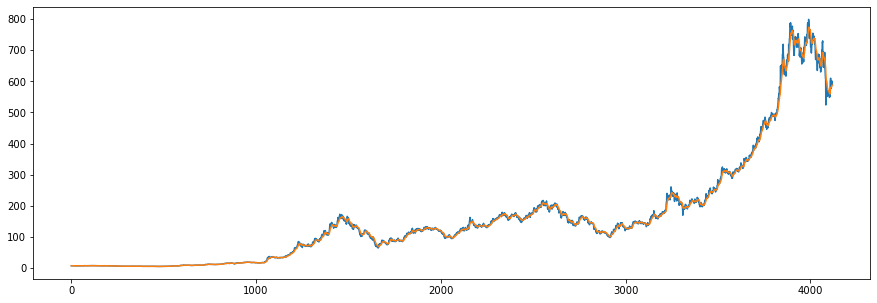

In [72]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []

seed = 10
df = pd.read_csv('data/noncyclic_tickers/initial_indicators/600519.SS_data.csv')
df.set_index('Date', inplace=True)
print(df.head())

plt.figure(figsize=(15,5))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
plt.show()

data_20_price = []
data_20_willr = []
data_20_ema = []
data_20_obv = []
count = 0

for i in df.values:
    if count == 19:
        data_20_price.append([i[0]])
        data_20_ema.append([i[1]])
        data_20_willr.append([i[2]])
        data_20_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_20_price_arr = min_max_scaler.fit_transform(data_20_price)
        data_20_ema_arr = min_max_scaler.fit_transform(data_20_ema)
        data_20_willr_arr = min_max_scaler.fit_transform(data_20_willr)
        data_20_obv_arr = min_max_scaler.fit_transform(data_20_obv)
        price_data.append(data_20_price_arr)
        willr_data.append(data_20_willr_arr)
        ema_data.append(data_20_ema_arr)
        obv_data.append(data_20_obv_arr)
        labels.append(i[-1])
        data_20_price = data_20_price[1:]
        data_20_willr = data_20_willr[1:]
        data_20_obv = data_20_obv[1:]
        data_20_ema = data_20_ema[1:]

    else:
        data_20_price.append([i[0]])
        data_20_ema.append([i[1]])
        data_20_willr.append([i[2]])
        data_20_obv.append([i[3]])
        count += 1

In [73]:
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)
obv_data.shape

(4101, 20, 1)

In [74]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [75]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

(4101, 64, 64, 1)

In [76]:
from collections import Counter

Counter(y)

Counter({2.0: 3733, 1.0: 183, 0.0: 185})

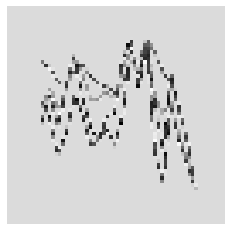

In [77]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [78]:
X = X/255

In [79]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [80]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [81]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [82]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.25, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [83]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

epochs = 0 
histories = {}
nr_log_hist = {}
r_log_hist = {}
column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
nr_log  = pd.DataFrame(columns = column_names)
r_log  = pd.DataFrame(columns = column_names)

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    print('\n')
    print('Non-Recession Test')
    print('\n')
        
    X = nr_test_data['{}_X'.format('600519.SS')]
    y = nr_test_data['{}_y'.format('600519.SS')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test.csv".format('600519.SS'))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data.csv".format('600519.SS'))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-5:]
    df2 = pd.concat([df2,df])
    df = df2.iloc[19:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    nr_length = len(nr_log)
    log.loc[df_length] = logger
    nr_log.loc[nr_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_non_recession.csv'.format(experiment,'600519.SS')):
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'600519.SS'))
    else:
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'600519.SS'), mode='a', header=False)
    
    
    print('\n')
    print('Recession Test')
    print('\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    log  = pd.DataFrame(columns = column_names)
    logger = []
        
    X = r_test_data['{}_X'.format('600519.SS')]
    y = r_test_data['{}_y'.format('600519.SS')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test2.csv".format('600519.SS'))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test.csv".format('600519.SS'))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-5:]
    df2 = pd.concat([df2,df])
    df = df2.iloc[19:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    r_length = len(r_log)
    log.loc[df_length] = logger
    r_log.loc[r_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_recession.csv'.format(experiment,'600519.SS')):
        log.to_csv('{}_{}_recession.csv'.format(experiment,'600519.SS'))
    else:
        log.to_csv('{}_{}_recession.csv'.format(experiment,'600519.SS'), mode='a', header=False)
    
    epochs = epochs + 20
    
nr_log_hist['epochs_logs'] = nr_log
r_log_hist['epochs_logs'] = r_log

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.387387387387387, 1: 7.488584474885845, 2: 0.3661531591873186}



RUNNING EPOCHS 0 - 20



Epoch 1/20
26/26 [==============================] - 0s 15ms/step - loss: 0.2509 - accuracy: 0.3119 - mse: 1.7319 - weighted_accuracy: 0.3107 - weighted_mse: 1.7596 - val_loss: 0.2027 - val_accuracy: 0.0451 - val_mse: 0.8980 - val_weighted_accuracy: 0.0451 - val_weighted_mse: 0.8980
Epoch 2/20
26/26 [==============================] - 0s 9ms/step - loss: 0.2043 - accuracy: 0.1985 - mse: 1.1885 - weighted_accuracy: 0.3557 - weighted_mse: 1.1940 - val_loss: 0.2005 - val_accuracy: 0.0475 - val_mse: 0.9627 - val_weighted_accuracy: 0.0475 - val_weighted_mse: 0.9627
Epoch 3/20
26/26 [==============================] - 0s 9ms/step - loss: 0.2063 - accuracy: 0.2820 - mse: 1.1737 - weighted_accuracy: 0.3023 - weighted_mse: 1.1748 - val_loss: 0.1936 - val_accuracy: 0.4689 - val_mse: 0.9441 - val_weighted_accuracy: 0.4689 - val_weighted_mse: 0.9441
Epoch 4/20
26/26 [==============================] - 0s 8m

<ipython-input-83-3c795054f12b>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-83-3c795054f12b>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-83-3c795054f12b>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

26/26 [==============================] - 0s 9ms/step - loss: 0.2017 - accuracy: 0.2793 - mse: 1.1817 - weighted_accuracy: 0.3376 - weighted_mse: 1.1733 - val_loss: 0.2057 - val_accuracy: 0.0585 - val_mse: 0.9872 - val_weighted_accuracy: 0.0585 - val_weighted_mse: 0.9872
Epoch 2/20
26/26 [==============================] - 0s 8ms/step - loss: 0.2006 - accuracy: 0.2881 - mse: 1.1830 - weighted_accuracy: 0.3556 - weighted_mse: 1.1728 - val_loss: 0.2054 - val_accuracy: 0.0487 - val_mse: 0.9948 - val_weighted_accuracy: 0.0487 - val_weighted_mse: 0.9948
Epoch 3/20
26/26 [==============================] - 0s 9ms/step - loss: 0.2007 - accuracy: 0.2771 - mse: 1.1840 - weighted_accuracy: 0.3433 - weighted_mse: 1.1714 - val_loss: 0.1965 - val_accuracy: 0.0548 - val_mse: 0.9943 - val_weighted_accuracy: 0.0548 - val_weighted_mse: 0.9943
Epoch 4/20
26/26 [==============================] - 0s 8ms/step - loss: 0.1998 - accuracy: 0.2784 - mse: 1.1841 - weighted_accuracy: 0.3543 - weighted_mse: 1.1706 - 

7/7 [==============================] - 0s 2ms/step - loss: 0.1967 - accuracy: 0.0962 - mse: 1.0031 - weighted_accuracy: 0.0962 - weighted_mse: 1.0031
Test loss: 0.19672520458698273
Test accuracy: 0.09615384787321091


number of predictions: 208
actual predicted buys: 9
actual buys but predicted sell: 0
actual buys but predicted hold: 0
actual sells but predicted buy: 6
actual predicted sells: 4
actual sells but predicted hold: 0
actual holds but predicted buy: 120
actual holds but predicted sell: 62
actual predicted holds: 7
Percentage buys correct: 6.666666666666667%
Percentage sells correct: 6.0606060606060606%
Percentage holds correct: 100.0%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 42.22222222222222%
Percentage high sells correct: 47.69230769230769%
Percentage mid holds correct: 100.0%


Capital: 100
Share price: $0.12558233818043063
Shares owned at the moment: 794
Cash capital at the moment: $0.013414449321103916


Price increase from previo

<ipython-input-83-3c795054f12b>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-83-3c795054f12b>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-83-3c795054f12b>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Epoch 1/20
26/26 [==============================] - 0s 10ms/step - loss: 0.1973 - accuracy: 0.2899 - mse: 1.1937 - weighted_accuracy: 0.3650 - weighted_mse: 1.1882 - val_loss: 0.1984 - val_accuracy: 0.0706 - val_mse: 0.9888 - val_weighted_accuracy: 0.0706 - val_weighted_mse: 0.9888
Epoch 2/20
26/26 [==============================] - 0s 8ms/step - loss: 0.1969 - accuracy: 0.2674 - mse: 1.1691 - weighted_accuracy: 0.3957 - weighted_mse: 1.1817 - val_loss: 0.1963 - val_accuracy: 0.2241 - val_mse: 0.8665 - val_weighted_accuracy: 0.2241 - val_weighted_mse: 0.8665
Epoch 3/20
26/26 [==============================] - 0s 8ms/step - loss: 0.1954 - accuracy: 0.2610 - mse: 1.1903 - weighted_accuracy: 0.3932 - weighted_mse: 1.1744 - val_loss: 0.1968 - val_accuracy: 0.0682 - val_mse: 1.1162 - val_weighted_accuracy: 0.0682 - val_weighted_mse: 1.1162
Epoch 4/20
26/26 [==============================] - 0s 8ms/step - loss: 0.1957 - accuracy: 0.2482 - mse: 1.1957 - weighted_accuracy: 0.3949 - weighted_ms

7/7 [==============================] - 0s 2ms/step - loss: 0.1971 - accuracy: 0.0673 - mse: 0.9243 - weighted_accuracy: 0.0673 - weighted_mse: 0.9243
Test loss: 0.19714882969856262
Test accuracy: 0.06730769574642181


number of predictions: 208
actual predicted buys: 9
actual buys but predicted sell: 0
actual buys but predicted hold: 0
actual sells but predicted buy: 5
actual predicted sells: 5
actual sells but predicted hold: 0
actual holds but predicted buy: 107
actual holds but predicted sell: 82
actual predicted holds: 0
Percentage buys correct: 7.43801652892562%
Percentage sells correct: 5.747126436781609%
Percentage holds correct: 0%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 42.97520661157025%
Percentage high sells correct: 47.674418604651166%
Percentage mid holds correct: 0%


Capital: 100
Share price: $0.12558233818043063
Shares owned at the moment: 794
Cash capital at the moment: $0.013414449321103916


Price increase from previously boug

<ipython-input-83-3c795054f12b>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-83-3c795054f12b>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-83-3c795054f12b>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Epoch 1/20
26/26 [==============================] - 0s 10ms/step - loss: 0.1872 - accuracy: 0.1607 - mse: 1.2375 - weighted_accuracy: 0.4708 - weighted_mse: 1.2284 - val_loss: 0.1974 - val_accuracy: 0.0694 - val_mse: 0.9920 - val_weighted_accuracy: 0.0694 - val_weighted_mse: 0.9920
Epoch 2/20
26/26 [==============================] - 0s 8ms/step - loss: 0.1876 - accuracy: 0.1616 - mse: 1.2099 - weighted_accuracy: 0.4560 - weighted_mse: 1.1850 - val_loss: 0.1977 - val_accuracy: 0.0670 - val_mse: 0.9724 - val_weighted_accuracy: 0.0670 - val_weighted_mse: 0.9724
Epoch 3/20
26/26 [==============================] - 0s 8ms/step - loss: 0.1862 - accuracy: 0.1409 - mse: 1.2070 - weighted_accuracy: 0.4741 - weighted_mse: 1.1748 - val_loss: 0.1953 - val_accuracy: 0.0682 - val_mse: 1.0203 - val_weighted_accuracy: 0.0682 - val_weighted_mse: 1.0203
Epoch 4/20
26/26 [==============================] - 0s 9ms/step - loss: 0.1821 - accuracy: 0.1573 - mse: 1.2486 - weighted_accuracy: 0.5171 - weighted_ms

7/7 [==============================] - 0s 2ms/step - loss: 0.1998 - accuracy: 0.0865 - mse: 1.0250 - weighted_accuracy: 0.0865 - weighted_mse: 1.0250
Test loss: 0.19982708990573883
Test accuracy: 0.08653846383094788


number of predictions: 208
actual predicted buys: 7
actual buys but predicted sell: 2
actual buys but predicted hold: 0
actual sells but predicted buy: 3
actual predicted sells: 7
actual sells but predicted hold: 0
actual holds but predicted buy: 85
actual holds but predicted sell: 100
actual predicted holds: 4
Percentage buys correct: 7.368421052631579%
Percentage sells correct: 6.422018348623853%
Percentage holds correct: 100.0%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 44.21052631578947%
Percentage high sells correct: 46.2962962962963%
Percentage mid holds correct: 100.0%


Capital: 100
Share price: $0.09936061724328947
Shares owned at the moment: 1003
Cash capital at the moment: $0.06723948246934697


Price increase from previous

<ipython-input-83-3c795054f12b>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-83-3c795054f12b>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-83-3c795054f12b>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

26/26 [==============================] - 0s 9ms/step - loss: 0.1728 - accuracy: 0.1424 - mse: 1.2872 - weighted_accuracy: 0.5503 - weighted_mse: 1.2503 - val_loss: 0.1990 - val_accuracy: 0.1364 - val_mse: 1.0659 - val_weighted_accuracy: 0.1364 - val_weighted_mse: 1.0659
Epoch 2/20
26/26 [==============================] - 0s 8ms/step - loss: 0.1710 - accuracy: 0.1491 - mse: 1.3299 - weighted_accuracy: 0.5678 - weighted_mse: 1.2772 - val_loss: 0.1965 - val_accuracy: 0.1279 - val_mse: 1.1053 - val_weighted_accuracy: 0.1279 - val_weighted_mse: 1.1053
Epoch 3/20
26/26 [==============================] - 0s 8ms/step - loss: 0.1732 - accuracy: 0.1378 - mse: 1.3236 - weighted_accuracy: 0.5311 - weighted_mse: 1.2853 - val_loss: 0.2051 - val_accuracy: 0.0792 - val_mse: 1.0347 - val_weighted_accuracy: 0.0792 - val_weighted_mse: 1.0347
Epoch 4/20
26/26 [==============================] - 0s 9ms/step - loss: 0.1736 - accuracy: 0.1485 - mse: 1.3219 - weighted_accuracy: 0.5287 - weighted_mse: 1.2846 - 

7/7 [==============================] - 0s 2ms/step - loss: 0.1931 - accuracy: 0.2212 - mse: 1.0814 - weighted_accuracy: 0.2212 - weighted_mse: 1.0814
Test loss: 0.19310131669044495
Test accuracy: 0.2211538404226303


number of predictions: 208
actual predicted buys: 6
actual buys but predicted sell: 2
actual buys but predicted hold: 1
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 2
actual holds but predicted buy: 63
actual holds but predicted sell: 93
actual predicted holds: 33
Percentage buys correct: 8.571428571428571%
Percentage sells correct: 6.862745098039215%
Percentage holds correct: 91.66666666666667%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 51.42857142857143%
Percentage high sells correct: 49.504950495049506%
Percentage mid holds correct: 86.11111111111111%


Capital: 100
Share price: $0.09936061724328947
Shares owned at the moment: 1003
Cash capital at the moment: $0.06723948246934697


Pri

<ipython-input-83-3c795054f12b>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-83-3c795054f12b>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-83-3c795054f12b>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

26/26 [==============================] - 0s 9ms/step - loss: 0.1629 - accuracy: 0.1680 - mse: 1.3570 - weighted_accuracy: 0.5682 - weighted_mse: 1.3233 - val_loss: 0.1964 - val_accuracy: 0.2083 - val_mse: 1.0799 - val_weighted_accuracy: 0.2083 - val_weighted_mse: 1.0799
Epoch 2/20
26/26 [==============================] - 0s 8ms/step - loss: 0.1611 - accuracy: 0.1692 - mse: 1.3850 - weighted_accuracy: 0.5795 - weighted_mse: 1.3714 - val_loss: 0.1919 - val_accuracy: 0.2582 - val_mse: 1.2069 - val_weighted_accuracy: 0.2582 - val_weighted_mse: 1.2069
Epoch 3/20
26/26 [==============================] - 0s 8ms/step - loss: 0.1592 - accuracy: 0.1768 - mse: 1.4209 - weighted_accuracy: 0.5906 - weighted_mse: 1.4054 - val_loss: 0.1942 - val_accuracy: 0.2229 - val_mse: 1.1976 - val_weighted_accuracy: 0.2229 - val_weighted_mse: 1.1976
Epoch 4/20
26/26 [==============================] - 0s 8ms/step - loss: 0.1668 - accuracy: 0.1643 - mse: 1.4038 - weighted_accuracy: 0.5494 - weighted_mse: 1.3305 - 

7/7 [==============================] - 0s 2ms/step - loss: 0.1863 - accuracy: 0.3269 - mse: 1.2167 - weighted_accuracy: 0.3269 - weighted_mse: 1.2167
Test loss: 0.18627764284610748
Test accuracy: 0.32692307233810425


number of predictions: 208
actual predicted buys: 5
actual buys but predicted sell: 1
actual buys but predicted hold: 3
actual sells but predicted buy: 1
actual predicted sells: 6
actual sells but predicted hold: 3
actual holds but predicted buy: 55
actual holds but predicted sell: 77
actual predicted holds: 57
Percentage buys correct: 8.19672131147541%
Percentage sells correct: 7.142857142857143%
Percentage holds correct: 90.47619047619048%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 55.73770491803279%
Percentage high sells correct: 49.397590361445786%
Percentage mid holds correct: 85.71428571428571%


Capital: 100
Share price: $0.11510518984487804
Shares owned at the moment: 866
Cash capital at the moment: $0.044782584720039154


Pri

<ipython-input-83-3c795054f12b>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-83-3c795054f12b>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-83-3c795054f12b>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

26/26 [==============================] - 0s 10ms/step - loss: 0.1520 - accuracy: 0.2207 - mse: 1.5298 - weighted_accuracy: 0.6176 - weighted_mse: 1.5697 - val_loss: 0.1887 - val_accuracy: 0.3264 - val_mse: 1.2916 - val_weighted_accuracy: 0.3264 - val_weighted_mse: 1.2916
Epoch 2/20
26/26 [==============================] - 0s 8ms/step - loss: 0.1521 - accuracy: 0.2265 - mse: 1.5113 - weighted_accuracy: 0.6134 - weighted_mse: 1.5314 - val_loss: 0.1888 - val_accuracy: 0.3216 - val_mse: 1.2912 - val_weighted_accuracy: 0.3216 - val_weighted_mse: 1.2912
Epoch 3/20
26/26 [==============================] - 0s 8ms/step - loss: 0.1486 - accuracy: 0.2226 - mse: 1.5562 - weighted_accuracy: 0.6247 - weighted_mse: 1.5658 - val_loss: 0.1923 - val_accuracy: 0.2887 - val_mse: 1.1998 - val_weighted_accuracy: 0.2887 - val_weighted_mse: 1.1998
Epoch 4/20
26/26 [==============================] - 0s 8ms/step - loss: 0.1506 - accuracy: 0.2341 - mse: 1.5230 - weighted_accuracy: 0.6205 - weighted_mse: 1.5298 -

7/7 [==============================] - 0s 2ms/step - loss: 0.1760 - accuracy: 0.4279 - mse: 1.3642 - weighted_accuracy: 0.4279 - weighted_mse: 1.3642
Test loss: 0.1760127693414688
Test accuracy: 0.42788460850715637


number of predictions: 208
actual predicted buys: 5
actual buys but predicted sell: 1
actual buys but predicted hold: 3
actual sells but predicted buy: 1
actual predicted sells: 6
actual sells but predicted hold: 3
actual holds but predicted buy: 45
actual holds but predicted sell: 66
actual predicted holds: 78
Percentage buys correct: 9.803921568627452%
Percentage sells correct: 8.219178082191782%
Percentage holds correct: 92.85714285714286%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 56.86274509803921%
Percentage high sells correct: 54.794520547945204%
Percentage mid holds correct: 87.95180722891567%


Capital: 100
Share price: $0.11510518984487804
Shares owned at the moment: 866
Cash capital at the moment: $0.044782584720039154


Pri

<ipython-input-83-3c795054f12b>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-83-3c795054f12b>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-83-3c795054f12b>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu


26/26 [==============================] - 0s 9ms/step - loss: 0.1440 - accuracy: 0.2832 - mse: 1.6475 - weighted_accuracy: 0.6384 - weighted_mse: 1.7409 - val_loss: 0.1773 - val_accuracy: 0.4263 - val_mse: 1.4411 - val_weighted_accuracy: 0.4263 - val_weighted_mse: 1.4411
Epoch 2/20
26/26 [==============================] - 0s 8ms/step - loss: 0.1437 - accuracy: 0.2915 - mse: 1.7089 - weighted_accuracy: 0.6350 - weighted_mse: 1.8046 - val_loss: 0.1860 - val_accuracy: 0.3508 - val_mse: 1.3851 - val_weighted_accuracy: 0.3508 - val_weighted_mse: 1.3851
Epoch 3/20
26/26 [==============================] - 0s 8ms/step - loss: 0.1401 - accuracy: 0.3006 - mse: 1.7065 - weighted_accuracy: 0.6662 - weighted_mse: 1.8561 - val_loss: 0.1814 - val_accuracy: 0.3983 - val_mse: 1.4265 - val_weighted_accuracy: 0.3983 - val_weighted_mse: 1.4265
Epoch 4/20
26/26 [==============================] - 0s 8ms/step - loss: 0.1448 - accuracy: 0.3003 - mse: 1.7113 - weighted_accuracy: 0.6450 - weighted_mse: 1.7590 -

7/7 [==============================] - 0s 2ms/step - loss: 0.1628 - accuracy: 0.5721 - mse: 1.5994 - weighted_accuracy: 0.5721 - weighted_mse: 1.5994
Test loss: 0.1628267914056778
Test accuracy: 0.5721153616905212


number of predictions: 208
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 5
actual sells but predicted buy: 0
actual predicted sells: 5
actual sells but predicted hold: 5
actual holds but predicted buy: 35
actual holds but predicted sell: 44
actual predicted holds: 110
Percentage buys correct: 10.256410256410257%
Percentage sells correct: 10.204081632653061%
Percentage holds correct: 91.66666666666667%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 64.1025641025641%
Percentage high sells correct: 55.10204081632653%
Percentage mid holds correct: 88.23529411764706%


Capital: 100
Share price: $0.11510518984487804
Shares owned at the moment: 866
Cash capital at the moment: $0.044782584720039154


Pri

<ipython-input-83-3c795054f12b>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-83-3c795054f12b>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-83-3c795054f12b>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

26/26 [==============================] - 0s 9ms/step - loss: 0.1347 - accuracy: 0.3655 - mse: 1.9419 - weighted_accuracy: 0.6835 - weighted_mse: 2.1343 - val_loss: 0.1718 - val_accuracy: 0.4848 - val_mse: 1.5805 - val_weighted_accuracy: 0.4848 - val_weighted_mse: 1.5805
Epoch 2/20
26/26 [==============================] - 0s 9ms/step - loss: 0.1340 - accuracy: 0.3674 - mse: 1.8584 - weighted_accuracy: 0.7103 - weighted_mse: 2.0386 - val_loss: 0.1788 - val_accuracy: 0.4519 - val_mse: 1.6533 - val_weighted_accuracy: 0.4519 - val_weighted_mse: 1.6533
Epoch 3/20
26/26 [==============================] - 0s 8ms/step - loss: 0.1368 - accuracy: 0.3768 - mse: 1.9120 - weighted_accuracy: 0.7005 - weighted_mse: 2.0846 - val_loss: 0.1720 - val_accuracy: 0.4836 - val_mse: 1.5359 - val_weighted_accuracy: 0.4836 - val_weighted_mse: 1.5359
Epoch 4/20
26/26 [==============================] - 0s 8ms/step - loss: 0.1345 - accuracy: 0.3753 - mse: 1.9178 - weighted_accuracy: 0.6916 - weighted_mse: 2.1673 - 

7/7 [==============================] - 0s 2ms/step - loss: 0.1519 - accuracy: 0.6538 - mse: 1.7806 - weighted_accuracy: 0.6538 - weighted_mse: 1.7806
Test loss: 0.15190553665161133
Test accuracy: 0.6538461446762085


number of predictions: 208
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 0
actual predicted sells: 4
actual sells but predicted hold: 6
actual holds but predicted buy: 24
actual holds but predicted sell: 36
actual predicted holds: 129
Percentage buys correct: 11.11111111111111%
Percentage sells correct: 10.0%
Percentage holds correct: 91.48936170212765%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 59.25925925925926%
Percentage high sells correct: 60.0%
Percentage mid holds correct: 87.14285714285714%


Capital: 100
Share price: $0.11351808346621216
Shares owned at the moment: 878
Cash capital at the moment: $0.05703330413655294


Price increase from previously

<ipython-input-83-3c795054f12b>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-83-3c795054f12b>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-83-3c795054f12b>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Epoch 1/20
26/26 [==============================] - 0s 9ms/step - loss: 0.1288 - accuracy: 0.4198 - mse: 2.1447 - weighted_accuracy: 0.6992 - weighted_mse: 2.5842 - val_loss: 0.1597 - val_accuracy: 0.5944 - val_mse: 1.7887 - val_weighted_accuracy: 0.5944 - val_weighted_mse: 1.7887
Epoch 2/20
26/26 [==============================] - 0s 9ms/step - loss: 0.1232 - accuracy: 0.4473 - mse: 2.1864 - weighted_accuracy: 0.7567 - weighted_mse: 2.6125 - val_loss: 0.1650 - val_accuracy: 0.5542 - val_mse: 1.7549 - val_weighted_accuracy: 0.5542 - val_weighted_mse: 1.7549
Epoch 3/20
26/26 [==============================] - 0s 9ms/step - loss: 0.1221 - accuracy: 0.4738 - mse: 2.1741 - weighted_accuracy: 0.7513 - weighted_mse: 2.7081 - val_loss: 0.1579 - val_accuracy: 0.6114 - val_mse: 1.8016 - val_weighted_accuracy: 0.6114 - val_weighted_mse: 1.8016
Epoch 4/20
26/26 [==============================] - 0s 8ms/step - loss: 0.1244 - accuracy: 0.4503 - mse: 2.2181 - weighted_accuracy: 0.7363 - weighted_mse

7/7 [==============================] - 0s 2ms/step - loss: 0.1445 - accuracy: 0.6779 - mse: 1.8779 - weighted_accuracy: 0.6779 - weighted_mse: 1.8779
Test loss: 0.14448224008083344
Test accuracy: 0.6778846383094788


number of predictions: 208
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 8
actual holds but predicted buy: 21
actual holds but predicted sell: 31
actual predicted holds: 137
Percentage buys correct: 8.695652173913043%
Percentage sells correct: 6.0606060606060606%
Percentage holds correct: 90.13157894736842%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 60.869565217391305%
Percentage high sells correct: 60.60606060606061%
Percentage mid holds correct: 86.09271523178808%


Capital: 100
Share price: $0.11351808346621216
Shares owned at the moment: 878
Cash capital at the moment: $0.05703330413655294


Pr

<ipython-input-83-3c795054f12b>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-83-3c795054f12b>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-83-3c795054f12b>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

In [84]:
df = r_log_hist['epochs_logs']
df.head(20)

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.048077,0.000000,4.807692,0.000000,0.000000,41.062802,0.000000,0.000000,678.794088
1,0.096154,6.666667,6.060606,100.000000,42.222222,47.692308,100.000000,901.085979,678.794088
2,0.067308,7.438017,5.747126,0.000000,42.975207,47.674419,0.000000,361.612750,678.794088
3,0.086538,7.368421,6.422018,100.000000,44.210526,46.296296,100.000000,554.799268,678.794088
4,0.221154,8.571429,6.862745,91.666667,51.428571,49.504950,86.111111,529.927057,678.794088
5,0.326923,8.196721,7.142857,90.476190,55.737705,49.397590,85.714286,425.648221,678.794088
6,0.427885,9.803922,8.219178,92.857143,56.862745,54.794521,87.951807,1471.976187,678.794088
7,0.572115,10.256410,10.204082,91.666667,64.102564,55.102041,88.235294,2837.522064,678.794088
8,0.653846,11.111111,10.000000,91.489362,59.259259,60.000000,87.142857,6950.172453,678.794088
9,0.677885,8.695652,6.060606,90.131579,60.869565,60.606061,86.092715,221.567195,678.794088


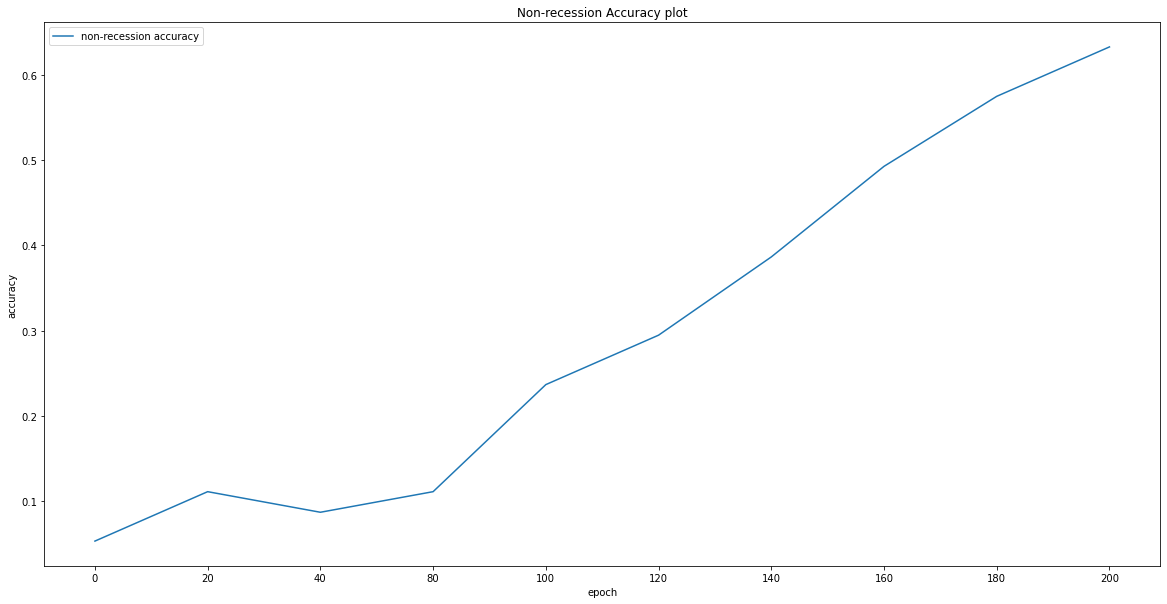

In [85]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(nr_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Non-recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['non-recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

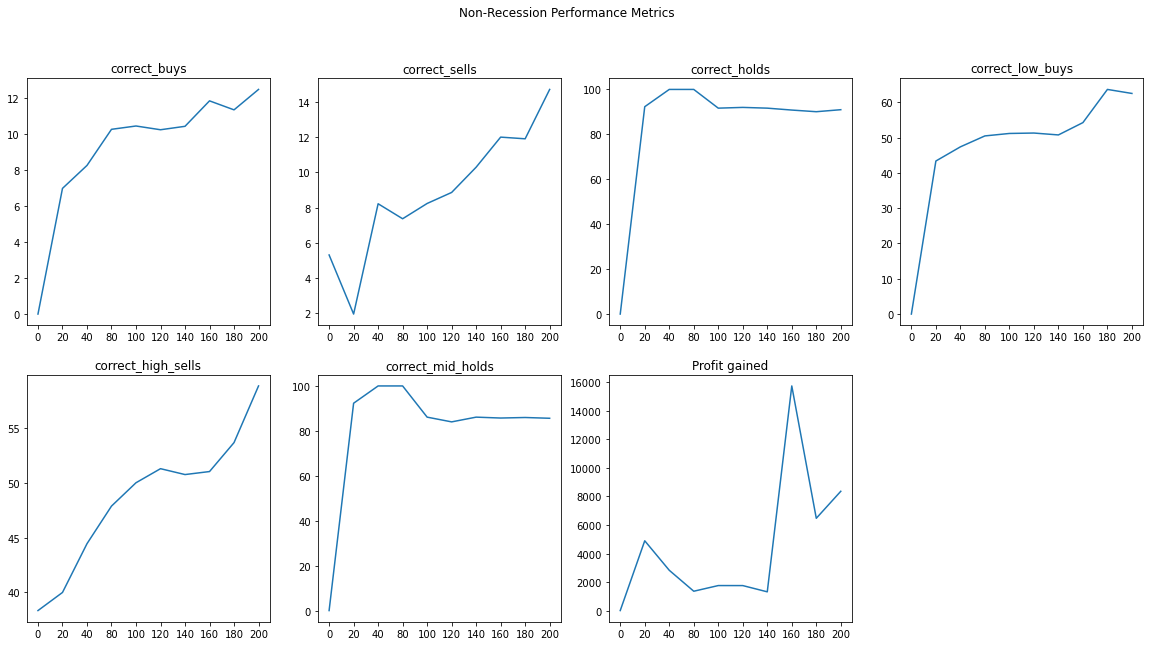

In [86]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(nr_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(nr_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(nr_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(nr_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(nr_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(nr_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(nr_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

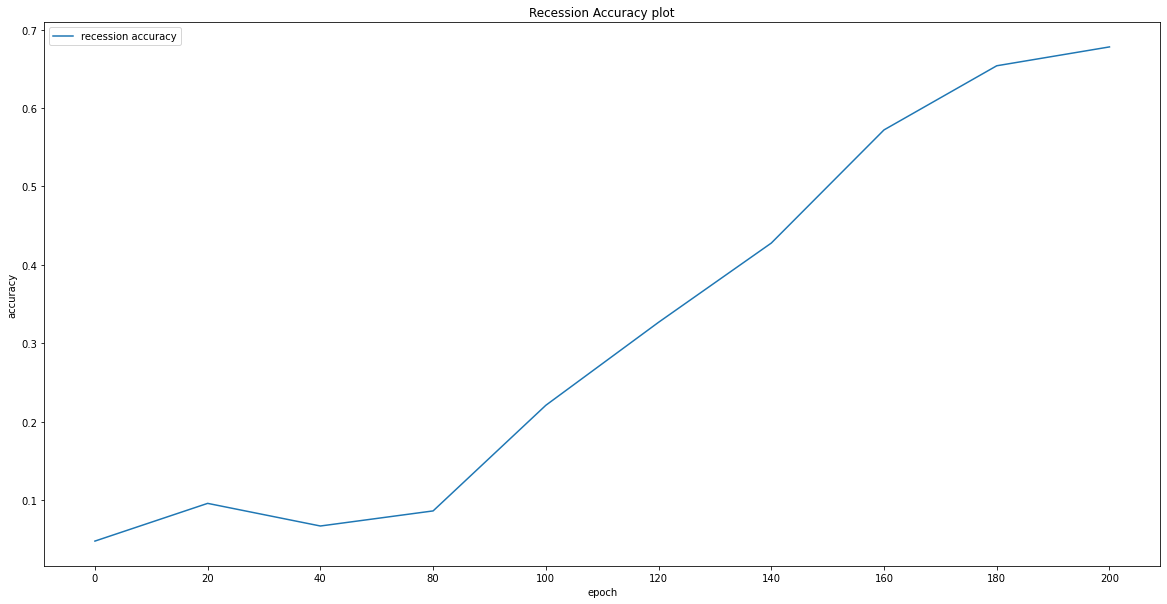

In [87]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(r_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

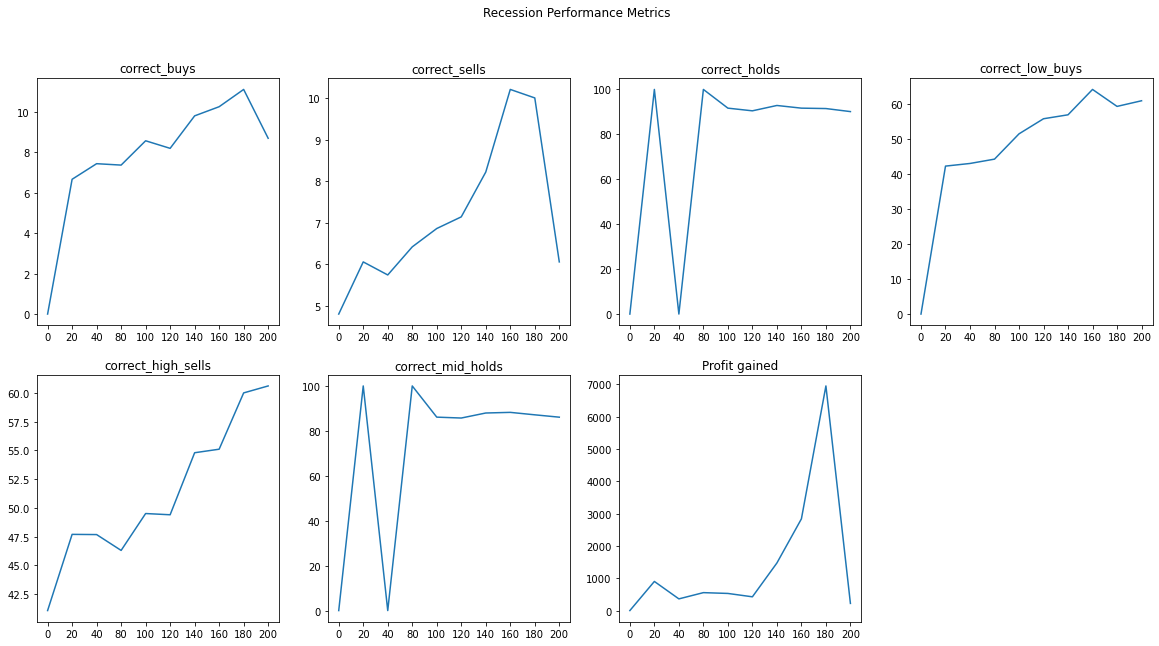

In [88]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(r_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(r_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(r_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(r_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(r_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(r_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(r_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

### midea

In [27]:
nr_test_sets = ['000333.SZ']
nr_test_data = {}

for name in nr_test_sets:

    df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test.csv".format(name))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data.csv".format(name))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-5:]
    df2 = pd.concat([df2,df])
    df = df2
    print(df.head())
    
    willr_data = []
    price_data = []
    ema_data = []
    obv_data = []
    labels = []
    data_20_price = []
    data_20_willr = []
    data_20_ema = []
    data_20_obv = []
    count = 0

    for i in df.values:
        if count == 19:
            data_20_price.append([i[0]])
            data_20_ema.append([i[1]])
            data_20_willr.append([i[2]])
            data_20_obv.append([i[3]])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_20_price_arr = min_max_scaler.fit_transform(data_20_price)
            data_20_ema_arr = min_max_scaler.fit_transform(data_20_ema)
            data_20_willr_arr = min_max_scaler.fit_transform(data_20_willr)
            data_20_obv_arr = min_max_scaler.fit_transform(data_20_obv)
            price_data.append(data_20_price_arr)
            willr_data.append(data_20_willr_arr)
            ema_data.append(data_20_ema_arr)
            obv_data.append(data_20_obv_arr)
            labels.append(i[-1])
            data_20_price = data_20_price[1:]
            data_20_willr = data_20_willr[1:]
            data_20_obv = data_20_obv[1:]
            data_20_ema = data_20_ema[1:]

        else:
            data_20_price.append([i[0]])
            data_20_ema.append([i[1]])
            data_20_willr.append([i[2]])
            data_20_obv.append([i[3]])
            count += 1

    willr_data = np.array(willr_data)
    price_data = np.array(price_data)
    ema_data = np.array(ema_data)
    obv_data = np.array(obv_data)
    
    sequential_data = []
    
    for i in range(0,len(willr_data)):
        j = willr_data[i]
        k = price_data[i]
        l = ema_data[i]
        m = obv_data[i]
        fig, ax = plt.subplots()
        fig.set_size_inches((5,5))

        ax.plot(k)
        ax.plot(j)
        ax.plot(l)
        ax.plot(m)

        ax.axis('off')

        fig.add_axes(ax)
        fig.canvas.draw()

        # this rasterized the figure
        X = np.array(fig.canvas.renderer._renderer)
        X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
        X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
        sequential_data.append(X)
        plt.close()
        
    X = sequential_data
    y = labels

    X  = np.array(X).reshape(-1, 64, 64, 1)
    X = X/255
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    nr_test_data['{}_X'.format(name)] = X
    nr_test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14         OBV_7  labels
Date                                                               
2018-12-13    37.740002  38.759611 -71.929776  4.973847e+09     2.0
2018-12-14    40.119999  38.968901 -19.383280  5.047660e+09     2.0
2018-12-17    39.750000  39.089070 -27.533034  5.015177e+09     2.0
2018-12-18    39.459999  39.146136 -33.920718  4.984902e+09     2.0
2018-12-19    38.810001  39.094423 -48.237845  4.952096e+09     2.0


In [28]:
r_test_sets = ['000333.SZ']
r_test_data = {}

for name in r_test_sets:

    df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test2.csv".format(name))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test.csv".format(name))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-5:]
    df2 = pd.concat([df2,df])
    df = df2
    print(df.head())
    
    willr_data = []
    price_data = []
    ema_data = []
    obv_data = []
    labels = []
    data_20_price = []
    data_20_willr = []
    data_20_ema = []
    data_20_obv = []
    count = 0

    for i in df.values:
        if count == 19:
            data_20_price.append([i[0]])
            data_20_ema.append([i[1]])
            data_20_willr.append([i[2]])
            data_20_obv.append([i[3]])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_20_price_arr = min_max_scaler.fit_transform(data_20_price)
            data_20_ema_arr = min_max_scaler.fit_transform(data_20_ema)
            data_20_willr_arr = min_max_scaler.fit_transform(data_20_willr)
            data_20_obv_arr = min_max_scaler.fit_transform(data_20_obv)
            price_data.append(data_20_price_arr)
            willr_data.append(data_20_willr_arr)
            ema_data.append(data_20_ema_arr)
            obv_data.append(data_20_obv_arr)
            labels.append(i[-1])
            data_20_price = data_20_price[1:]
            data_20_willr = data_20_willr[1:]
            data_20_obv = data_20_obv[1:]
            data_20_ema = data_20_ema[1:]

        else:
            data_20_price.append([i[0]])
            data_20_ema.append([i[1]])
            data_20_willr.append([i[2]])
            data_20_obv.append([i[3]])
            count += 1

    willr_data = np.array(willr_data)
    price_data = np.array(price_data)
    ema_data = np.array(ema_data)
    obv_data = np.array(obv_data)
    
    sequential_data = []
    
    for i in range(0,len(willr_data)):
        j = willr_data[i]
        k = price_data[i]
        l = ema_data[i]
        m = obv_data[i]
        fig, ax = plt.subplots()
        fig.set_size_inches((5,5))

        ax.plot(k)
        ax.plot(j)
        ax.plot(l)
        ax.plot(m)

        ax.axis('off')

        fig.add_axes(ax)
        fig.canvas.draw()

        # this rasterized the figure
        X = np.array(fig.canvas.renderer._renderer)
        X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
        X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
        sequential_data.append(X)
        plt.close()
        
    X = sequential_data
    y = labels

    X  = np.array(X).reshape(-1, 64, 64, 1)
    X = X/255
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    r_test_data['{}_X'.format(name)] = X
    r_test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14         OBV_7  labels
Date                                                               
2019-12-16    58.400002  56.667715  -2.074657  1.246874e+09     2.0
2019-12-17    58.110001  56.889605  -8.091274  1.225225e+09     0.0
2019-12-18    58.500000  57.137358  -8.538913  1.250810e+09     2.0
2019-12-19    58.200001  57.300842 -19.572930  1.227161e+09     2.0
2019-12-20    58.080002  57.420713 -23.018822  1.213685e+09     2.0


### training Data

            previous_1d     EMA_12   willr_14        OBV_7  labels
Date                                                              
2013-10-17    11.912000  11.900182 -34.022038  235647532.0     1.0
2013-10-18    11.896000  11.899539 -39.103542  214825024.0     2.0
2013-10-21    12.269333  11.956430 -24.093825  253903732.0     2.0
2013-10-22    12.760000  12.080056  -4.424713  304775737.0     2.0
2013-10-23    12.645333  12.167022 -15.187657  273970459.0     2.0


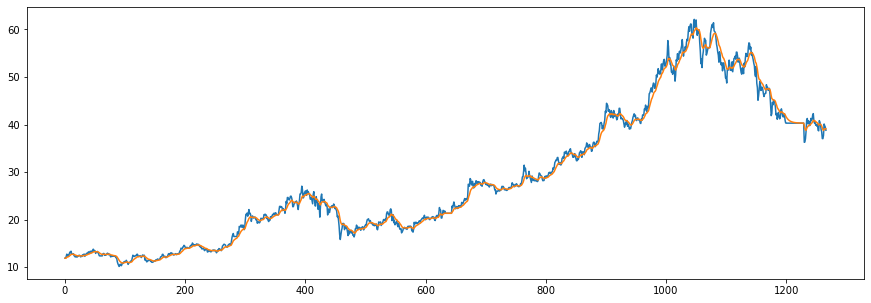

(1248, 64, 64, 1)

In [29]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []

seed = 10
df = pd.read_csv('data/noncyclic_tickers/initial_indicators/000333.SZ_data.csv')
df.set_index('Date', inplace=True)
print(df.head())

plt.figure(figsize=(15,5))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
plt.show()

data_20_price = []
data_20_willr = []
data_20_ema = []
data_20_obv = []
count = 0

for i in df.values:
    if count == 19:
        data_20_price.append([i[0]])
        data_20_ema.append([i[1]])
        data_20_willr.append([i[2]])
        data_20_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_20_price_arr = min_max_scaler.fit_transform(data_20_price)
        data_20_ema_arr = min_max_scaler.fit_transform(data_20_ema)
        data_20_willr_arr = min_max_scaler.fit_transform(data_20_willr)
        data_20_obv_arr = min_max_scaler.fit_transform(data_20_obv)
        price_data.append(data_20_price_arr)
        willr_data.append(data_20_willr_arr)
        ema_data.append(data_20_ema_arr)
        obv_data.append(data_20_obv_arr)
        labels.append(i[-1])
        data_20_price = data_20_price[1:]
        data_20_willr = data_20_willr[1:]
        data_20_obv = data_20_obv[1:]
        data_20_ema = data_20_ema[1:]

    else:
        data_20_price.append([i[0]])
        data_20_ema.append([i[1]])
        data_20_willr.append([i[2]])
        data_20_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()
    
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

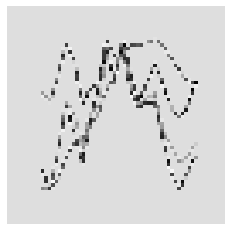

In [30]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [31]:
X = X/255

In [32]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [33]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [34]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [35]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.25, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [36]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

epochs = 0 
histories = {}
nr_log_hist = {}
r_log_hist = {}
column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
nr_log  = pd.DataFrame(columns = column_names)
r_log  = pd.DataFrame(columns = column_names)

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    print('\n')
    print('Non-Recession Test')
    print('\n')
        
    X = nr_test_data['{}_X'.format('000333.SZ')]
    y = nr_test_data['{}_y'.format('000333.SZ')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test.csv".format('000333.SZ'))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data.csv".format('000333.SZ'))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-5:]
    df2 = pd.concat([df2,df])
    df = df2.iloc[19:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    nr_length = len(nr_log)
    log.loc[df_length] = logger
    nr_log.loc[nr_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_non_recession.csv'.format(experiment,'000333.SZ')):
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'000333.SZ'))
    else:
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'000333.SZ'), mode='a', header=False)
    
    
    print('\n')
    print('Recession Test')
    print('\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    log  = pd.DataFrame(columns = column_names)
    logger = []
        
    X = r_test_data['{}_X'.format('000333.SZ')]
    y = r_test_data['{}_y'.format('000333.SZ')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test2.csv".format('000333.SZ'))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test.csv".format('000333.SZ'))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-5:]
    df2 = pd.concat([df2,df])
    df = df2.iloc[19:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    r_length = len(r_log)
    log.loc[df_length] = logger
    r_log.loc[r_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_recession.csv'.format(experiment,'000333.SZ')):
        log.to_csv('{}_{}_recession.csv'.format(experiment,'000333.SZ'))
    else:
        log.to_csv('{}_{}_recession.csv'.format(experiment,'000333.SZ'), mode='a', header=False)
    
    epochs = epochs + 20
    
nr_log_hist['epochs_logs'] = nr_log
r_log_hist['epochs_logs'] = r_log

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 0 2 2 2 2 2 2 2 1 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 1 2 2 2 2 2
 1 0 1 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 2 2 2 2 2 2 2 2 2 2 2 2
 2 0 2 1 2 2 2 2 2 0 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 1 2 2 2 2 1 2 2 2 2
 2 2 2 2 1 2 2 0 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 0
 2 2 2 0 0 1 2 2 2 2 2 2 2 0 2 2 1 1 2 1 2 2 0 2 0 2 2 2 2 2 2 2 2 0 2 2 2
 2 2 1 1 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 1 2 2 2 2 2 

{0: 7.920634920634921, 1: 6.789115646258503, 2: 0.3667769202499081}



RUNNING EPOCHS 0 - 20



Epoch 1/20
8/8 [==============================] - 0s 52ms/step - loss: 0.3174 - accuracy: 0.3988 - mse: 2.8343 - weighted_accuracy: 0.2852 - weighted_mse: 3.0960 - val_loss: 0.2412 - val_accuracy: 0.0400 - val_mse: 0.9649 - val_weighted_accuracy: 0.0400 - val_weighted_mse: 0.9649
Epoch 2/20
8/8 [==============================] - 0s 13ms/step - loss: 0.2249 - accuracy: 0.2495 - mse: 1.2731 - weighted_accuracy: 0.4204 - weighted_mse: 1.1835 - val_loss: 0.2061 - val_accuracy: 0.0560 - val_mse: 1.1070 - val_weighted_accuracy: 0.0560 - val_weighted_mse: 1.1070
Epoch 3/20
8/8 [==============================] - 0s 13ms/step - loss: 0.2126 - accuracy: 0.2996 - mse: 1.5103 - weighted_accuracy: 0.3306 - weighted_mse: 1.4437 - val_loss: 0.2048 - val_accuracy: 0.1520 - val_mse: 0.8823 - val_weighted_accuracy: 0.1520 - val_weighted_mse: 0.8823
Epoch 4/20
8/8 [==============================] - 0s 13ms/ste

<ipython-input-36-102cc319b203>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-36-102cc319b203>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-36-102cc319b203>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

number of predictions: 208
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 0
actual sells but predicted buy: 8
actual predicted sells: 0
actual sells but predicted hold: 0
actual holds but predicted buy: 193
actual holds but predicted sell: 0
actual predicted holds: 0
Percentage buys correct: 3.3653846153846154%
Percentage sells correct: 0%
Percentage holds correct: 0%
actual buys: 7
actual sells: 8
actual holds: 193


Percentage low buys correct: 42.028985507246375%
Percentage high sells correct: 0%
Percentage mid holds correct: 0%


Capital: 100
Share price: $0.15749262821393872
Shares owned at the moment: 633
Cash capital at the moment: $0.033011048013364075




Capital at the end of test period: $568.5733088396158
profit gained: 468.5733088396159%


Capital at the end of test period if Buy and Hold: $568.5733088396158
profit gained: 468.5733088396159%
   Test_accuracy  correct_buys  correct_sells  correct_holds  \
0       0.033654      3.3

7/7 [==============================] - 0s 2ms/step - loss: 0.2033 - accuracy: 0.0385 - mse: 0.9710 - weighted_accuracy: 0.0385 - weighted_mse: 0.9710
Test loss: 0.2033310979604721
Test accuracy: 0.03846153989434242


number of predictions: 208
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 0
actual sells but predicted buy: 7
actual predicted sells: 1
actual sells but predicted hold: 0
actual holds but predicted buy: 163
actual holds but predicted sell: 30
actual predicted holds: 0
Percentage buys correct: 3.9548022598870056%
Percentage sells correct: 3.225806451612903%
Percentage holds correct: 0%
actual buys: 7
actual sells: 8
actual holds: 193


Percentage low buys correct: 42.04545454545455%
Percentage high sells correct: 51.61290322580645%
Percentage mid holds correct: 0%


Capital: 100
Share price: $0.15749262821393872
Shares owned at the moment: 633
Cash capital at the moment: $0.033011048013364075


Price increase from previously bough

<ipython-input-36-102cc319b203>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-36-102cc319b203>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-36-102cc319b203>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Epoch 1/20
8/8 [==============================] - 0s 16ms/step - loss: 0.1955 - accuracy: 0.2385 - mse: 1.1922 - weighted_accuracy: 0.3535 - weighted_mse: 1.1833 - val_loss: 0.2049 - val_accuracy: 0.0560 - val_mse: 0.9424 - val_weighted_accuracy: 0.0560 - val_weighted_mse: 0.9424
Epoch 2/20
8/8 [==============================] - ETA: 0s - loss: 0.2022 - accuracy: 0.2723 - mse: 1.1569 - weighted_accuracy: 0.3847 - weighted_mse: 1.159 - 0s 13ms/step - loss: 0.1980 - accuracy: 0.2766 - mse: 1.1626 - weighted_accuracy: 0.4050 - weighted_mse: 1.1674 - val_loss: 0.1994 - val_accuracy: 0.0520 - val_mse: 0.9365 - val_weighted_accuracy: 0.0520 - val_weighted_mse: 0.9365
Epoch 3/20
8/8 [==============================] - 0s 13ms/step - loss: 0.2000 - accuracy: 0.2856 - mse: 1.1996 - weighted_accuracy: 0.2887 - weighted_mse: 1.2062 - val_loss: 0.2003 - val_accuracy: 0.0560 - val_mse: 0.9061 - val_weighted_accuracy: 0.0560 - val_weighted_mse: 0.9061
Epoch 4/20
8/8 [==============================] -

7/7 [==============================] - 0s 3ms/step - loss: 0.1997 - accuracy: 0.0433 - mse: 1.1303 - weighted_accuracy: 0.0433 - weighted_mse: 1.1303
Test loss: 0.19973652064800262
Test accuracy: 0.04326923191547394




<ipython-input-36-102cc319b203>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-36-102cc319b203>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-36-102cc319b203>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

number of predictions: 208
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 0
actual sells but predicted buy: 6
actual predicted sells: 2
actual sells but predicted hold: 0
actual holds but predicted buy: 128
actual holds but predicted sell: 65
actual predicted holds: 0
Percentage buys correct: 4.964539007092198%
Percentage sells correct: 2.985074626865672%
Percentage holds correct: 0%
actual buys: 7
actual sells: 8
actual holds: 193


Percentage low buys correct: 45.39007092198582%
Percentage high sells correct: 51.515151515151516%
Percentage mid holds correct: 0%


Capital: 100
Share price: $0.1863590200873636
Shares owned at the moment: 535
Cash capital at the moment: $0.023743544956943197


Price increase from previously bought: 6.9419572353609516%
Share price: $0.19984404752087281
Shares owned at the moment: 0
Cash capital at the moment: $106.6462884137088


Share price: $0.149907280188314
Shares owned at the moment: 709
Cash capital at th

8/8 [==============================] - 0s 12ms/step - loss: 0.1968 - accuracy: 0.3277 - mse: 1.1720 - weighted_accuracy: 0.3670 - weighted_mse: 1.1479 - val_loss: 0.1923 - val_accuracy: 0.2760 - val_mse: 0.9768 - val_weighted_accuracy: 0.2760 - val_weighted_mse: 0.9768
Epoch 8/20
8/8 [==============================] - 0s 12ms/step - loss: 0.1970 - accuracy: 0.3297 - mse: 1.2552 - weighted_accuracy: 0.3643 - weighted_mse: 1.2387 - val_loss: 0.1985 - val_accuracy: 0.0880 - val_mse: 0.9762 - val_weighted_accuracy: 0.0880 - val_weighted_mse: 0.9762
Epoch 9/20
8/8 [==============================] - 0s 13ms/step - loss: 0.1915 - accuracy: 0.3246 - mse: 1.1665 - weighted_accuracy: 0.4132 - weighted_mse: 1.1599 - val_loss: 0.1923 - val_accuracy: 0.1560 - val_mse: 0.9790 - val_weighted_accuracy: 0.1560 - val_weighted_mse: 0.9790
Epoch 10/20
8/8 [==============================] - 0s 12ms/step - loss: 0.1944 - accuracy: 0.3166 - mse: 1.2279 - weighted_accuracy: 0.3822 - weighted_mse: 1.2132 - val

<ipython-input-36-102cc319b203>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-36-102cc319b203>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-36-102cc319b203>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Epoch 1/20
8/8 [==============================] - 0s 17ms/step - loss: 0.1972 - accuracy: 0.3016 - mse: 1.1936 - weighted_accuracy: 0.3809 - weighted_mse: 1.2057 - val_loss: 0.2045 - val_accuracy: 0.0600 - val_mse: 1.0515 - val_weighted_accuracy: 0.0600 - val_weighted_mse: 1.0515
Epoch 2/20
8/8 [==============================] - 0s 13ms/step - loss: 0.1917 - accuracy: 0.2575 - mse: 1.1954 - weighted_accuracy: 0.3844 - weighted_mse: 1.1497 - val_loss: 0.1927 - val_accuracy: 0.1240 - val_mse: 0.9687 - val_weighted_accuracy: 0.1240 - val_weighted_mse: 0.9687
Epoch 3/20
8/8 [==============================] - 0s 13ms/step - loss: 0.1917 - accuracy: 0.3196 - mse: 1.2517 - weighted_accuracy: 0.4231 - weighted_mse: 1.2326 - val_loss: 0.1977 - val_accuracy: 0.0600 - val_mse: 1.0170 - val_weighted_accuracy: 0.0600 - val_weighted_mse: 1.0170
Epoch 4/20
8/8 [==============================] - 0s 15ms/step - loss: 0.1909 - accuracy: 0.2375 - mse: 1.1679 - weighted_accuracy: 0.4463 - weighted_mse: 1.


Share price: $0.5883555732246311
Shares owned at the moment: 21458
Cash capital at the moment: $0.10029798898904119


Price increase from previously bought: -4.919682013400739%
Share price: $0.5609487283761212
Shares owned at the moment: 0
Cash capital at the moment: $12003.836807496687


Share price: $0.5757062189754254
Shares owned at the moment: 20793
Cash capital at the moment: $0.25808295998649555


Price increase from previously bought: -5.630397209541426%
Share price: $0.544785724185316
Shares owned at the moment: 0
Cash capital at the moment: $11296.836389647053


Share price: $0.5820308961000282
Shares owned at the moment: 19356
Cash capital at the moment: $0.06544216639667866


Price increase from previously bought: 64.62581744949063%
Share price: $0.9608080965946784
Shares owned at the moment: 0
Cash capital at the moment: $18546.324105679352


Share price: $0.7787982416470054
Shares owned at the moment: 23748
Cash capital at the moment: $0.562486279024597


Price increase 

<ipython-input-36-102cc319b203>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-36-102cc319b203>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-36-102cc319b203>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

number of predictions: 208
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 0
actual sells but predicted buy: 6
actual predicted sells: 2
actual sells but predicted hold: 0
actual holds but predicted buy: 132
actual holds but predicted sell: 61
actual predicted holds: 0
Percentage buys correct: 4.827586206896552%
Percentage sells correct: 3.1746031746031744%
Percentage holds correct: 0%
actual buys: 7
actual sells: 8
actual holds: 193


Percentage low buys correct: 46.206896551724135%
Percentage high sells correct: 48.38709677419355%
Percentage mid holds correct: 0%


Capital: 100
Share price: $0.17624524951223164
Shares owned at the moment: 565
Cash capital at the moment: $0.14759296915948994


Price increase from previously bought: -1.824165189125837%
Share price: $0.17350607819695518
Shares owned at the moment: 0
Cash capital at the moment: $97.90894208144064


Share price: $0.1863590200873636
Shares owned at the moment: 523
Cash capital at 

8/8 [==============================] - 0s 14ms/step - loss: 0.1785 - accuracy: 0.2164 - mse: 1.2910 - weighted_accuracy: 0.5169 - weighted_mse: 1.2939 - val_loss: 0.1865 - val_accuracy: 0.0640 - val_mse: 1.1115 - val_weighted_accuracy: 0.0640 - val_weighted_mse: 1.1115
Epoch 8/20
8/8 [==============================] - 0s 14ms/step - loss: 0.1833 - accuracy: 0.2184 - mse: 1.1589 - weighted_accuracy: 0.5336 - weighted_mse: 1.1460 - val_loss: 0.1925 - val_accuracy: 0.0600 - val_mse: 1.0021 - val_weighted_accuracy: 0.0600 - val_weighted_mse: 1.0021
Epoch 9/20
8/8 [==============================] - 0s 14ms/step - loss: 0.1799 - accuracy: 0.2515 - mse: 1.2551 - weighted_accuracy: 0.4950 - weighted_mse: 1.2701 - val_loss: 0.1910 - val_accuracy: 0.0600 - val_mse: 1.0550 - val_weighted_accuracy: 0.0600 - val_weighted_mse: 1.0550
Epoch 10/20
8/8 [==============================] - 0s 13ms/step - loss: 0.1791 - accuracy: 0.1974 - mse: 1.2829 - weighted_accuracy: 0.5398 - weighted_mse: 1.2811 - val

7/7 [==============================] - 0s 3ms/step - loss: 0.1961 - accuracy: 0.0433 - mse: 0.9999 - weighted_accuracy: 0.0433 - weighted_mse: 0.9999
Test loss: 0.19607298076152802
Test accuracy: 0.04326923191547394




<ipython-input-36-102cc319b203>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-36-102cc319b203>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-36-102cc319b203>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

number of predictions: 208
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 0
actual sells but predicted buy: 6
actual predicted sells: 2
actual sells but predicted hold: 0
actual holds but predicted buy: 134
actual holds but predicted sell: 59
actual predicted holds: 0
Percentage buys correct: 4.761904761904762%
Percentage sells correct: 3.278688524590164%
Percentage holds correct: 0%
actual buys: 7
actual sells: 8
actual holds: 193


Percentage low buys correct: 46.57534246575342%
Percentage high sells correct: 50.81967213114754%
Percentage mid holds correct: 0%


Capital: 100
Share price: $0.15749262821393872
Shares owned at the moment: 633
Cash capital at the moment: $0.033011048013364075


Price increase from previously bought: 17.337126723000896%
Share price: $0.1853055173898276
Shares owned at the moment: 0
Cash capital at the moment: $117.00883297637789


Share price: $0.17624524951223164
Shares owned at the moment: 662
Cash capital at 

8/8 [==============================] - 0s 14ms/step - loss: 0.1789 - accuracy: 0.1703 - mse: 1.2293 - weighted_accuracy: 0.5697 - weighted_mse: 1.1869 - val_loss: 0.1980 - val_accuracy: 0.0640 - val_mse: 1.1266 - val_weighted_accuracy: 0.0640 - val_weighted_mse: 1.1266
Epoch 5/20
8/8 [==============================] - 0s 14ms/step - loss: 0.1772 - accuracy: 0.1804 - mse: 1.3237 - weighted_accuracy: 0.5196 - weighted_mse: 1.3168 - val_loss: 0.1917 - val_accuracy: 0.0600 - val_mse: 1.0099 - val_weighted_accuracy: 0.0600 - val_weighted_mse: 1.0099
Epoch 6/20
8/8 [==============================] - 0s 14ms/step - loss: 0.1732 - accuracy: 0.2275 - mse: 1.2061 - weighted_accuracy: 0.6057 - weighted_mse: 1.1953 - val_loss: 0.1922 - val_accuracy: 0.0640 - val_mse: 1.0268 - val_weighted_accuracy: 0.0640 - val_weighted_mse: 1.0268
Epoch 7/20
8/8 [==============================] - 0s 13ms/step - loss: 0.1734 - accuracy: 0.1834 - mse: 1.3066 - weighted_accuracy: 0.5540 - weighted_mse: 1.2618 - val_

7/7 [==============================] - 0s 2ms/step - loss: 0.1914 - accuracy: 0.1442 - mse: 1.0931 - weighted_accuracy: 0.1442 - weighted_mse: 1.0931
Test loss: 0.19141584634780884
Test accuracy: 0.14423076808452606




<ipython-input-36-102cc319b203>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-36-102cc319b203>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-36-102cc319b203>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

number of predictions: 208
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 0
actual sells but predicted buy: 5
actual predicted sells: 2
actual sells but predicted hold: 1
actual holds but predicted buy: 103
actual holds but predicted sell: 69
actual predicted holds: 21
Percentage buys correct: 6.086956521739131%
Percentage sells correct: 2.816901408450704%
Percentage holds correct: 95.45454545454545%
actual buys: 7
actual sells: 8
actual holds: 193


Percentage low buys correct: 49.56521739130435%
Percentage high sells correct: 54.285714285714285%
Percentage mid holds correct: 81.81818181818181%


Capital: 100
Share price: $0.17624524951223164
Shares owned at the moment: 565
Cash capital at the moment: $0.14759296915948994


Price increase from previously bought: -1.824165189125837%
Share price: $0.17350607819695518
Shares owned at the moment: 0
Cash capital at the moment: $97.90894208144064


Share price: $0.1863590200873636
Shares owned at 

8/8 [==============================] - 0s 14ms/step - loss: 0.1635 - accuracy: 0.1914 - mse: 1.3636 - weighted_accuracy: 0.6152 - weighted_mse: 1.3738 - val_loss: 0.1975 - val_accuracy: 0.1000 - val_mse: 1.0601 - val_weighted_accuracy: 0.1000 - val_weighted_mse: 1.0601
Epoch 6/20
8/8 [==============================] - 0s 14ms/step - loss: 0.1656 - accuracy: 0.2004 - mse: 1.2351 - weighted_accuracy: 0.6110 - weighted_mse: 1.2257 - val_loss: 0.1947 - val_accuracy: 0.1120 - val_mse: 1.0535 - val_weighted_accuracy: 0.1120 - val_weighted_mse: 1.0535
Epoch 7/20
8/8 [==============================] - 0s 14ms/step - loss: 0.1588 - accuracy: 0.2144 - mse: 1.3336 - weighted_accuracy: 0.6623 - weighted_mse: 1.3608 - val_loss: 0.1953 - val_accuracy: 0.0920 - val_mse: 1.0988 - val_weighted_accuracy: 0.0920 - val_weighted_mse: 1.0988
Epoch 8/20
8/8 [==============================] - 0s 13ms/step - loss: 0.1623 - accuracy: 0.2224 - mse: 1.3040 - weighted_accuracy: 0.6016 - weighted_mse: 1.3314 - val_

7/7 [==============================] - 0s 3ms/step - loss: 0.1985 - accuracy: 0.0673 - mse: 1.0563 - weighted_accuracy: 0.0673 - weighted_mse: 1.0563
Test loss: 0.1985323280096054
Test accuracy: 0.06730769574642181




<ipython-input-36-102cc319b203>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-36-102cc319b203>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-36-102cc319b203>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

number of predictions: 208
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 0
actual sells but predicted buy: 6
actual predicted sells: 2
actual sells but predicted hold: 0
actual holds but predicted buy: 107
actual holds but predicted sell: 81
actual predicted holds: 5
Percentage buys correct: 5.833333333333333%
Percentage sells correct: 2.4096385542168677%
Percentage holds correct: 100.0%
actual buys: 7
actual sells: 8
actual holds: 193


Percentage low buys correct: 48.333333333333336%
Percentage high sells correct: 50.0%
Percentage mid holds correct: 100.0%


Capital: 100
Share price: $0.15749262821393872
Shares owned at the moment: 633
Cash capital at the moment: $0.033011048013364075


Price increase from previously bought: 17.337126723000896%
Share price: $0.1853055173898276
Shares owned at the moment: 0
Cash capital at the moment: $117.00883297637789


Share price: $0.17624524951223164
Shares owned at the moment: 662
Cash capital at the

8/8 [==============================] - 0s 12ms/step - loss: 0.1492 - accuracy: 0.2265 - mse: 1.4778 - weighted_accuracy: 0.6667 - weighted_mse: 1.5442 - val_loss: 0.1928 - val_accuracy: 0.2440 - val_mse: 1.1723 - val_weighted_accuracy: 0.2440 - val_weighted_mse: 1.1723
Epoch 3/20
8/8 [==============================] - 0s 12ms/step - loss: 0.1581 - accuracy: 0.2295 - mse: 1.4021 - weighted_accuracy: 0.5947 - weighted_mse: 1.4071 - val_loss: 0.1889 - val_accuracy: 0.2760 - val_mse: 1.0590 - val_weighted_accuracy: 0.2760 - val_weighted_mse: 1.0590
Epoch 4/20
8/8 [==============================] - 0s 12ms/step - loss: 0.1563 - accuracy: 0.2625 - mse: 1.3457 - weighted_accuracy: 0.6273 - weighted_mse: 1.3999 - val_loss: 0.1951 - val_accuracy: 0.2200 - val_mse: 1.0980 - val_weighted_accuracy: 0.2200 - val_weighted_mse: 1.0980
Epoch 5/20
8/8 [==============================] - 0s 13ms/step - loss: 0.1549 - accuracy: 0.2174 - mse: 1.3414 - weighted_accuracy: 0.6430 - weighted_mse: 1.3982 - val_

7/7 [==============================] - 0s 3ms/step - loss: 0.1796 - accuracy: 0.4087 - mse: 1.2431 - weighted_accuracy: 0.4087 - weighted_mse: 1.2431
Test loss: 0.17964805662631989
Test accuracy: 0.4086538553237915


number of predictions: 208
actual predicted buys: 6
actual buys but predicted sell: 0
actual buys but predicted hold: 1
actual sells but predicted buy: 3
actual predicted sells: 2
actual sells but predicted hold: 3
actual holds but predicted buy: 70
actual holds but predicted sell: 46
actual predicted holds: 77
Percentage buys correct: 7.594936708860759%
Percentage sells correct: 4.166666666666667%
Percentage holds correct: 95.06172839506173%
actual buys: 7
actual sells: 8
actual holds: 193


Percentage low buys correct: 50.63291139240506%
Percentage high sells correct: 56.25%
Percentage mid holds correct: 86.25%


Capital: 100
Share price: $0.1743489125058254
Shares owned at the moment: 571
Cash capital at the moment: $0.17299957931140852


Price increase from previously 

<ipython-input-36-102cc319b203>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-36-102cc319b203>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-36-102cc319b203>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Epoch 1/20
8/8 [==============================] - 0s 15ms/step - loss: 0.1532 - accuracy: 0.2826 - mse: 1.5800 - weighted_accuracy: 0.6464 - weighted_mse: 1.6879 - val_loss: 0.1976 - val_accuracy: 0.2400 - val_mse: 1.1170 - val_weighted_accuracy: 0.2400 - val_weighted_mse: 1.1170
Epoch 2/20
8/8 [==============================] - 0s 13ms/step - loss: 0.1455 - accuracy: 0.2776 - mse: 1.3043 - weighted_accuracy: 0.6941 - weighted_mse: 1.3990 - val_loss: 0.1875 - val_accuracy: 0.3680 - val_mse: 1.0753 - val_weighted_accuracy: 0.3680 - val_weighted_mse: 1.0753
Epoch 3/20
8/8 [==============================] - 0s 13ms/step - loss: 0.1523 - accuracy: 0.2956 - mse: 1.4588 - weighted_accuracy: 0.6307 - weighted_mse: 1.4798 - val_loss: 0.1856 - val_accuracy: 0.3360 - val_mse: 1.2525 - val_weighted_accuracy: 0.3360 - val_weighted_mse: 1.2525
Epoch 4/20
8/8 [==============================] - 0s 13ms/step - loss: 0.1432 - accuracy: 0.2956 - mse: 1.5585 - weighted_accuracy: 0.6606 - weighted_mse: 1.

7/7 [==============================] - 0s 4ms/step - loss: 0.1769 - accuracy: 0.4904 - mse: 1.2233 - weighted_accuracy: 0.4904 - weighted_mse: 1.2233
Test loss: 0.17687779664993286
Test accuracy: 0.49038460850715637




<ipython-input-36-102cc319b203>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-36-102cc319b203>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-36-102cc319b203>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

number of predictions: 208
actual predicted buys: 5
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 3
actual predicted sells: 2
actual sells but predicted hold: 3
actual holds but predicted buy: 55
actual holds but predicted sell: 43
actual predicted holds: 95
Percentage buys correct: 7.936507936507937%
Percentage sells correct: 4.444444444444445%
Percentage holds correct: 95.0%
actual buys: 7
actual sells: 8
actual holds: 193


Percentage low buys correct: 55.55555555555556%
Percentage high sells correct: 57.77777777777778%
Percentage mid holds correct: 84.84848484848484%


Capital: 100
Share price: $0.1743489125058254
Shares owned at the moment: 571
Cash capital at the moment: $0.17299957931140852


Price increase from previously bought: 1.292531515244555%
Share price: $0.17708808382110208
Shares owned at the moment: 0
Cash capital at the moment: $101.01222287754061


Share price: $0.061833104338965154
Shares owned at the moment: 16

<ipython-input-36-102cc319b203>:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


In [37]:
df = r_log_hist['epochs_logs']
df.head(20)

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.033654,3.365385,0.000000,0.000000,42.028986,0.000000,0.000000,468.573309,468.573309
1,0.038462,3.954802,3.225806,0.000000,42.045455,51.612903,0.000000,130.628360,468.573309
2,0.043269,4.964539,2.985075,0.000000,45.390071,51.515152,0.000000,192.055937,468.573309
3,0.197115,3.184713,0.000000,87.804878,41.025641,40.000000,78.048780,272.698900,468.573309
4,0.043269,4.827586,3.174603,0.000000,46.206897,48.387097,0.000000,146.706668,468.573309
5,0.043269,4.761905,3.278689,0.000000,46.575342,50.819672,0.000000,175.811966,468.573309
6,0.144231,6.086957,2.816901,95.454545,49.565217,54.285714,81.818182,188.548861,468.573309
7,0.067308,5.833333,2.409639,100.000000,48.333333,50.000000,100.000000,142.821376,468.573309
8,0.408654,7.594937,4.166667,95.061728,50.632911,56.250000,86.250000,172.153298,468.573309
9,0.490385,7.936508,4.444444,95.000000,55.555556,57.777778,84.848485,401.128232,468.573309


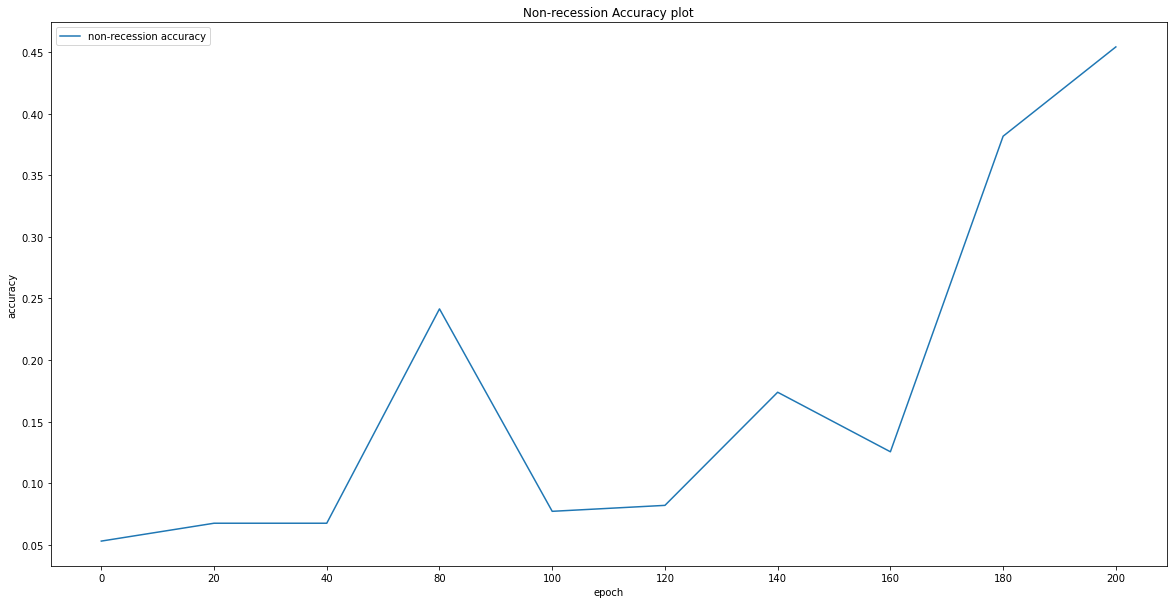

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(nr_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Non-recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['non-recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

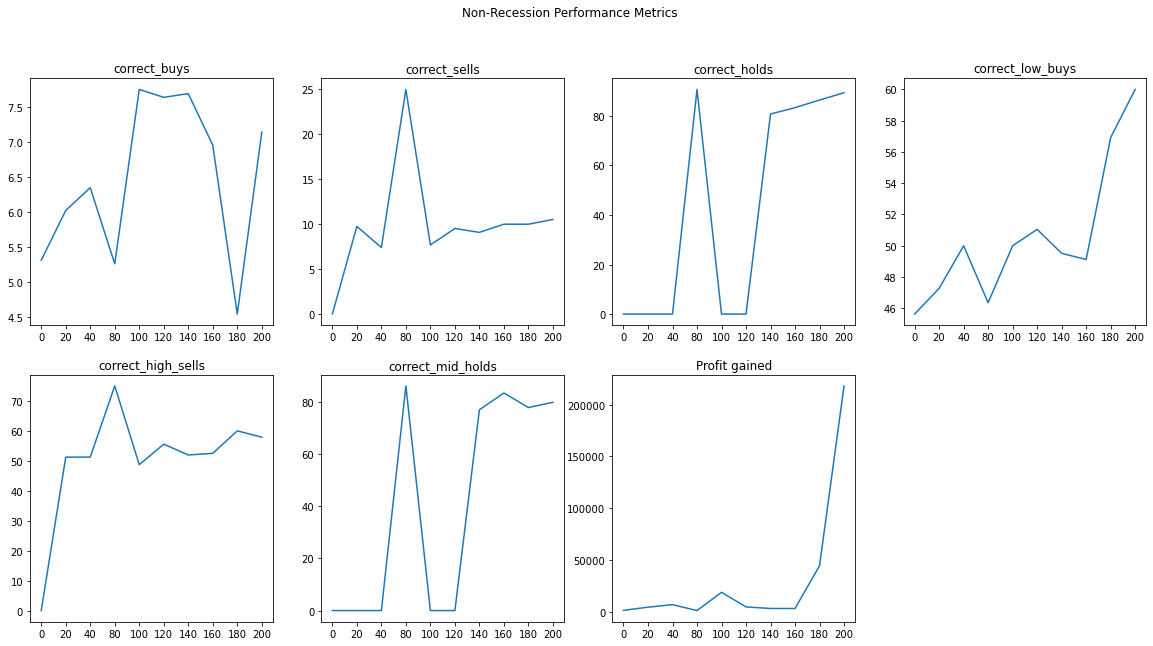

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(nr_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(nr_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(nr_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(nr_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(nr_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(nr_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(nr_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

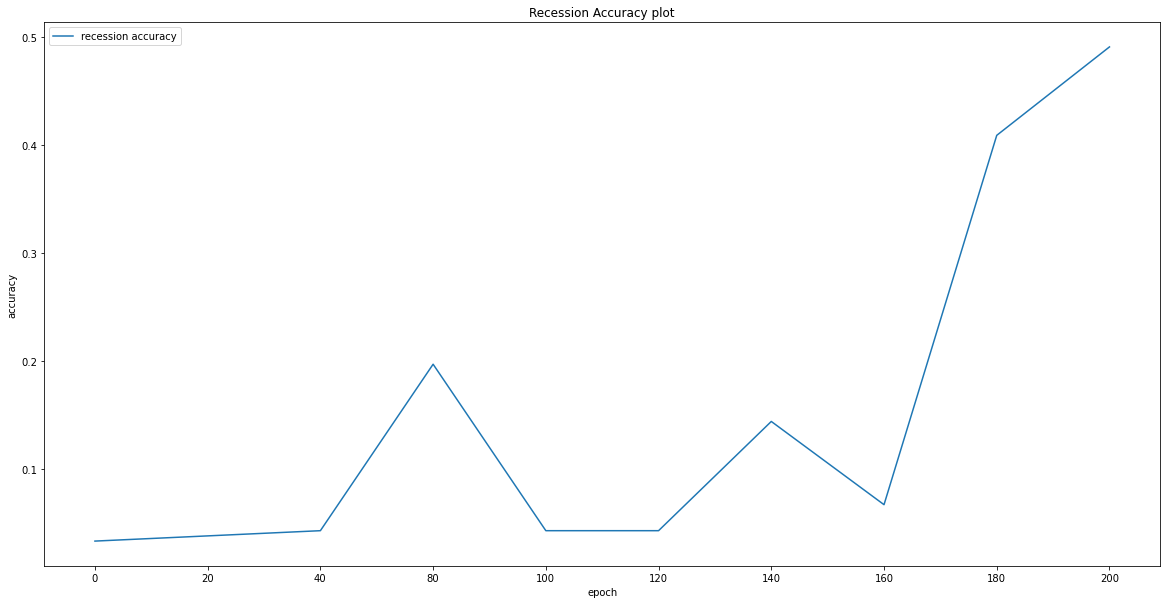

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(r_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

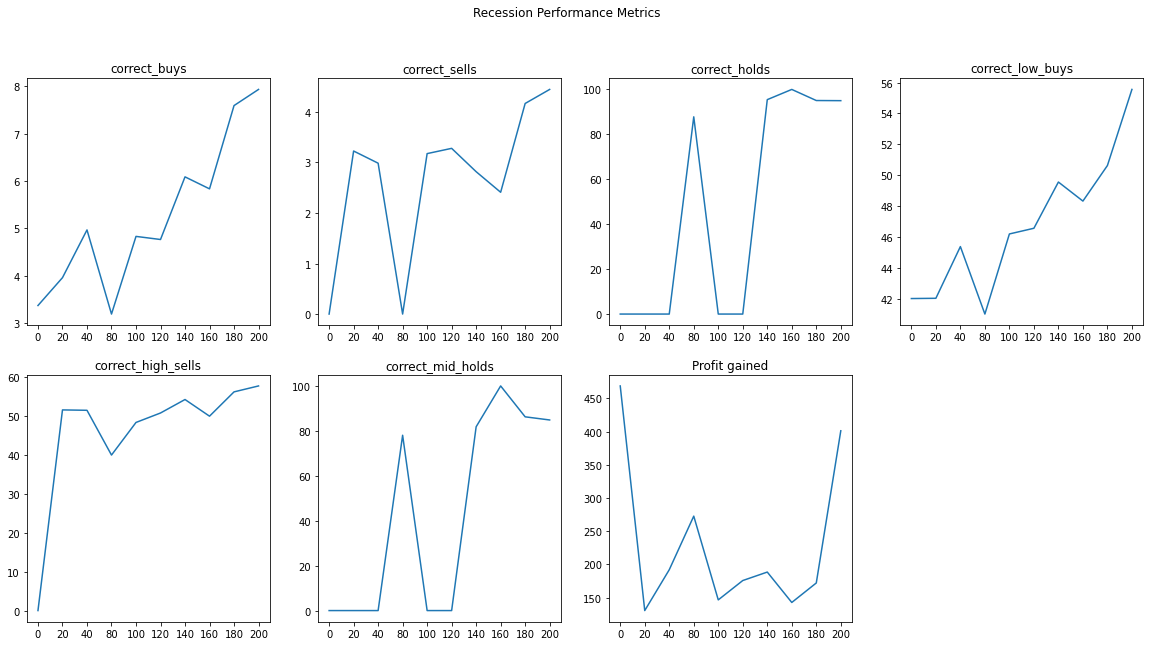

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(r_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(r_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(r_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(r_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(r_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(r_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(r_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

### Walmart

In [42]:
nr_test_sets = ['WMT']
nr_test_data = {}

for name in nr_test_sets:

    df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test.csv".format(name))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data.csv".format(name))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-5:]
    df2 = pd.concat([df2,df])
    df = df2
    print(df.head())
    
    willr_data = []
    price_data = []
    ema_data = []
    obv_data = []
    labels = []
    data_20_price = []
    data_20_willr = []
    data_20_ema = []
    data_20_obv = []
    count = 0

    for i in df.values:
        if count == 19:
            data_20_price.append([i[0]])
            data_20_ema.append([i[1]])
            data_20_willr.append([i[2]])
            data_20_obv.append([i[3]])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_20_price_arr = min_max_scaler.fit_transform(data_20_price)
            data_20_ema_arr = min_max_scaler.fit_transform(data_20_ema)
            data_20_willr_arr = min_max_scaler.fit_transform(data_20_willr)
            data_20_obv_arr = min_max_scaler.fit_transform(data_20_obv)
            price_data.append(data_20_price_arr)
            willr_data.append(data_20_willr_arr)
            ema_data.append(data_20_ema_arr)
            obv_data.append(data_20_obv_arr)
            labels.append(i[-1])
            data_20_price = data_20_price[1:]
            data_20_willr = data_20_willr[1:]
            data_20_obv = data_20_obv[1:]
            data_20_ema = data_20_ema[1:]

        else:
            data_20_price.append([i[0]])
            data_20_ema.append([i[1]])
            data_20_willr.append([i[2]])
            data_20_obv.append([i[3]])
            count += 1

    willr_data = np.array(willr_data)
    price_data = np.array(price_data)
    ema_data = np.array(ema_data)
    obv_data = np.array(obv_data)
    
    sequential_data = []
    
    for i in range(0,len(willr_data)):
        j = willr_data[i]
        k = price_data[i]
        l = ema_data[i]
        m = obv_data[i]
        fig, ax = plt.subplots()
        fig.set_size_inches((5,5))

        ax.plot(k)
        ax.plot(j)
        ax.plot(l)
        ax.plot(m)

        ax.axis('off')

        fig.add_axes(ax)
        fig.canvas.draw()

        # this rasterized the figure
        X = np.array(fig.canvas.renderer._renderer)
        X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
        X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
        sequential_data.append(X)
        plt.close()
        
    X = sequential_data
    y = labels

    X  = np.array(X).reshape(-1, 64, 64, 1)
    X = X/255
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    nr_test_data['{}_X'.format(name)] = X
    nr_test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2018-12-13    93.110001  95.261110 -89.379251  98530500.0     2.0
2018-12-14    92.959999  94.907093 -91.448238  90488200.0     2.0
2018-12-17    91.849998  94.436771 -96.508742  78994600.0     2.0
2018-12-18    90.769997  93.872652 -93.531353  69992800.0     2.0
2018-12-19    91.080002  93.443013 -90.243914  79599500.0     2.0


In [43]:
r_test_sets = ['WMT']
r_test_data = {}

for name in r_test_sets:

    df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test2.csv".format(name))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test.csv".format(name))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-5:]
    df2 = pd.concat([df2,df])
    df = df2
    print(df.head())
    
    willr_data = []
    price_data = []
    ema_data = []
    obv_data = []
    labels = []
    data_20_price = []
    data_20_willr = []
    data_20_ema = []
    data_20_obv = []
    count = 0

    for i in df.values:
        if count == 19:
            data_20_price.append([i[0]])
            data_20_ema.append([i[1]])
            data_20_willr.append([i[2]])
            data_20_obv.append([i[3]])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_20_price_arr = min_max_scaler.fit_transform(data_20_price)
            data_20_ema_arr = min_max_scaler.fit_transform(data_20_ema)
            data_20_willr_arr = min_max_scaler.fit_transform(data_20_willr)
            data_20_obv_arr = min_max_scaler.fit_transform(data_20_obv)
            price_data.append(data_20_price_arr)
            willr_data.append(data_20_willr_arr)
            ema_data.append(data_20_ema_arr)
            obv_data.append(data_20_obv_arr)
            labels.append(i[-1])
            data_20_price = data_20_price[1:]
            data_20_willr = data_20_willr[1:]
            data_20_obv = data_20_obv[1:]
            data_20_ema = data_20_ema[1:]

        else:
            data_20_price.append([i[0]])
            data_20_ema.append([i[1]])
            data_20_willr.append([i[2]])
            data_20_obv.append([i[3]])
            count += 1

    willr_data = np.array(willr_data)
    price_data = np.array(price_data)
    ema_data = np.array(ema_data)
    obv_data = np.array(obv_data)
    
    sequential_data = []
    
    for i in range(0,len(willr_data)):
        j = willr_data[i]
        k = price_data[i]
        l = ema_data[i]
        m = obv_data[i]
        fig, ax = plt.subplots()
        fig.set_size_inches((5,5))

        ax.plot(k)
        ax.plot(j)
        ax.plot(l)
        ax.plot(m)

        ax.axis('off')

        fig.add_axes(ax)
        fig.canvas.draw()

        # this rasterized the figure
        X = np.array(fig.canvas.renderer._renderer)
        X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
        X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
        sequential_data.append(X)
        plt.close()
        
    X = sequential_data
    y = labels

    X  = np.array(X).reshape(-1, 64, 64, 1)
    X = X/255
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    r_test_data['{}_X'.format(name)] = X
    r_test_data['{}_y'.format(name)] = y

            previous_1d      EMA_12   willr_14        OBV_7  labels
Date                                                               
2019-12-13   119.760002  119.241902 -18.750000  211183700.0     2.0
2019-12-16   120.290001  119.403148 -11.145518  216550000.0     2.0
2019-12-17   120.540001  119.578049 -20.610623  221900700.0     0.0
2019-12-18   121.279999  119.839887  -9.813044  226476500.0     2.0
2019-12-19   119.860001  119.842981 -42.990581  221373500.0     2.0


### Training Data

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2000-01-21      63.3750  65.176128 -85.271318 -26649200.0     2.0
2000-01-24      62.4375  64.754801 -94.594595 -33601700.0     2.0
2000-01-25      59.3750  63.927139 -83.606557 -41401600.0     2.0
2000-01-26      61.1250  63.496041 -68.306011 -34997800.0     2.0
2000-01-27      61.9375  63.256265 -61.202186 -30459400.0     2.0


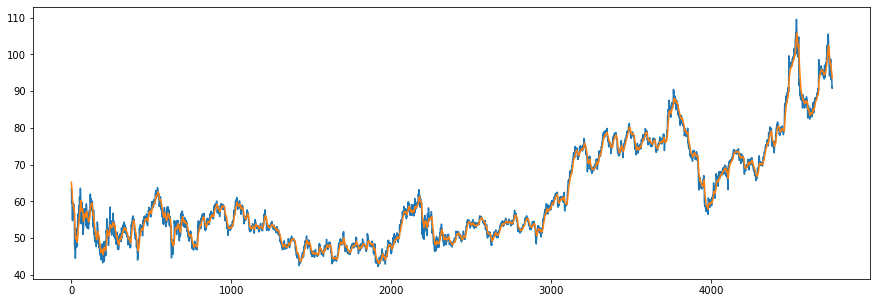

(4740, 64, 64, 1)

In [44]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []

seed = 10
df = pd.read_csv('data/noncyclic_tickers/initial_indicators/WMT_data.csv')
df.set_index('Date', inplace=True)
print(df.head())

plt.figure(figsize=(15,5))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
plt.show()

data_20_price = []
data_20_willr = []
data_20_ema = []
data_20_obv = []
count = 0

for i in df.values:
    if count == 19:
        data_20_price.append([i[0]])
        data_20_ema.append([i[1]])
        data_20_willr.append([i[2]])
        data_20_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_20_price_arr = min_max_scaler.fit_transform(data_20_price)
        data_20_ema_arr = min_max_scaler.fit_transform(data_20_ema)
        data_20_willr_arr = min_max_scaler.fit_transform(data_20_willr)
        data_20_obv_arr = min_max_scaler.fit_transform(data_20_obv)
        price_data.append(data_20_price_arr)
        willr_data.append(data_20_willr_arr)
        ema_data.append(data_20_ema_arr)
        obv_data.append(data_20_obv_arr)
        labels.append(i[-1])
        data_20_price = data_20_price[1:]
        data_20_willr = data_20_willr[1:]
        data_20_obv = data_20_obv[1:]
        data_20_ema = data_20_ema[1:]

    else:
        data_20_price.append([i[0]])
        data_20_ema.append([i[1]])
        data_20_willr.append([i[2]])
        data_20_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()
    
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

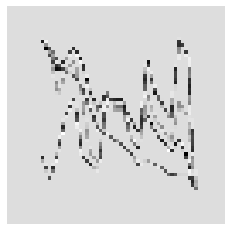

In [45]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [46]:
X = X/255

In [47]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [48]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [49]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [50]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.25, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [51]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

epochs = 0 
histories = {}
nr_log_hist = {}
r_log_hist = {}
column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
nr_log  = pd.DataFrame(columns = column_names)
r_log  = pd.DataFrame(columns = column_names)

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    print('\n')
    print('Non-Recession Test')
    print('\n')
        
    X = nr_test_data['{}_X'.format('WMT')]
    y = nr_test_data['{}_y'.format('WMT')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test.csv".format('WMT'))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data.csv".format('WMT'))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-5:]
    df2 = pd.concat([df2,df])
    df = df2.iloc[19:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    nr_length = len(nr_log)
    log.loc[df_length] = logger
    nr_log.loc[nr_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_non_recession.csv'.format(experiment,'WMT')):
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'WMT'))
    else:
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'WMT'), mode='a', header=False)
    
    
    print('\n')
    print('Recession Test')
    print('\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    log  = pd.DataFrame(columns = column_names)
    logger = []
        
    X = r_test_data['{}_X'.format('WMT')]
    y = r_test_data['{}_y'.format('WMT')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test2.csv".format('WMT'))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test.csv".format('WMT'))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-5:]
    df2 = pd.concat([df2,df])
    df = df2.iloc[19:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    r_length = len(r_log)
    log.loc[df_length] = logger
    r_log.loc[r_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_recession.csv'.format(experiment,'WMT')):
        log.to_csv('{}_{}_recession.csv'.format(experiment,'WMT'))
    else:
        log.to_csv('{}_{}_recession.csv'.format(experiment,'WMT'), mode='a', header=False)
    
    epochs = epochs + 20
    
nr_log_hist['epochs_logs'] = nr_log
r_log_hist['epochs_logs'] = r_log

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 0 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.141242937853107, 1: 7.348837209302325, 2: 0.36712169619517865}



RUNNING EPOCHS 0 - 20



Epoch 1/20
30/30 [==============================] - 1s 28ms/step - loss: 0.2472 - accuracy: 0.4409 - mse: 1.5752 - weighted_accuracy: 0.3500 - weighted_mse: 1.6995 - val_loss: 0.1923 - val_accuracy: 0.7869 - val_mse: 0.8559 - val_weighted_accuracy: 0.7869 - val_weighted_mse: 0.8559
Epoch 2/20
30/30 [==============================] - 1s 17ms/step - loss: 0.2044 - accuracy: 0.4723 - mse: 1.1766 - weighted_accuracy: 0.3504 - weighted_mse: 1.1883 - val_loss: 0.1987 - val_accuracy: 0.3312 - val_mse: 0.9081 - val_weighted_accuracy: 0.3312 - val_weighted_mse: 0.9081
Epoch 3/20
30/30 [==============================] - 1s 17ms/step - loss: 0.2054 - accuracy: 0.3914 - mse: 1.1658 - weighted_accuracy: 0.3170 - weighted_mse: 1.1680 - val_loss: 0.1945 - val_accuracy: 0.1688 - val_mse: 0.8818 - val_weighted_accuracy: 0.1688 - val_weighted_mse: 0.8818
Epoch 4/20
30/30 [==============================] - 1s

<ipython-input-51-8f6091318856>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-51-8f6091318856>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-51-8f6091318856>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

7/7 [==============================] - 0s 20ms/step - loss: 0.1900 - accuracy: 0.5251 - mse: 0.9450 - weighted_accuracy: 0.5251 - weighted_mse: 0.9450
Test loss: 0.18999925255775452
Test accuracy: 0.5251141786575317


number of predictions: 219
actual predicted buys: 0
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 8
actual sells but predicted hold: 3
actual holds but predicted buy: 2
actual holds but predicted sell: 92
actual predicted holds: 107
Percentage buys correct: 0.0%
Percentage sells correct: 8.0%
Percentage holds correct: 91.45299145299145%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 100.0%
Percentage high sells correct: 44.0%
Percentage mid holds correct: 87.06896551724138%


Capital: 100
Share price: $0.3971563171524608
Shares owned at the moment: 251
Cash capital at the moment: $0.03962724681785801


Price increase from previously bought: 10.18393612857269%


<ipython-input-51-8f6091318856>:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-51-8f6091318856>:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-51-8f6091318856>:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

Epoch 1/20
30/30 [==============================] - 1s 23ms/step - loss: 0.2026 - accuracy: 0.3790 - mse: 1.1956 - weighted_accuracy: 0.3400 - weighted_mse: 1.1809 - val_loss: 0.1980 - val_accuracy: 0.1624 - val_mse: 0.8722 - val_weighted_accuracy: 0.1624 - val_weighted_mse: 0.8722
Epoch 2/20
30/30 [==============================] - 1s 21ms/step - loss: 0.1989 - accuracy: 0.3341 - mse: 1.1700 - weighted_accuracy: 0.3562 - weighted_mse: 1.1622 - val_loss: 0.1952 - val_accuracy: 0.2152 - val_mse: 0.9235 - val_weighted_accuracy: 0.2152 - val_weighted_mse: 0.9235
Epoch 3/20
30/30 [==============================] - 1s 24ms/step - loss: 0.1996 - accuracy: 0.3465 - mse: 1.1904 - weighted_accuracy: 0.3342 - weighted_mse: 1.1710 - val_loss: 0.1908 - val_accuracy: 0.0527 - val_mse: 0.9865 - val_weighted_accuracy: 0.0527 - val_weighted_mse: 0.9865
Epoch 4/20
30/30 [==============================] - 1s 22ms/step - loss: 0.2004 - accuracy: 0.3289 - mse: 1.1539 - weighted_accuracy: 0.3743 - weighted

1/7 [===>..........................] - ETA: 0s - loss: 0.1957 - accuracy: 0.1562 - mse: 0.9708 - weighted_accuracy: 0.1562 - weighted_mse: 0.9708

<ipython-input-51-8f6091318856>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-51-8f6091318856>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-51-8f6091318856>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

7/7 [==============================] - 0s 6ms/step - loss: 0.1941 - accuracy: 0.1050 - mse: 0.9717 - weighted_accuracy: 0.1050 - weighted_mse: 0.9717
Test loss: 0.19407062232494354
Test accuracy: 0.10502283275127411


number of predictions: 219
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 0
actual sells but predicted buy: 3
actual predicted sells: 8
actual sells but predicted hold: 0
actual holds but predicted buy: 117
actual holds but predicted sell: 76
actual predicted holds: 8
Percentage buys correct: 5.511811023622047%
Percentage sells correct: 9.523809523809524%
Percentage holds correct: 100.0%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 51.58730158730159%
Percentage high sells correct: 51.19047619047619%
Percentage mid holds correct: 87.5%


Capital: 100
Share price: $0.24286829602432447
Shares owned at the moment: 410
Cash capital at the moment: $0.15016462625953864


Price increase from previousl

<ipython-input-51-8f6091318856>:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-51-8f6091318856>:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-51-8f6091318856>:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

Epoch 1/20
30/30 [==============================] - 1s 21ms/step - loss: 0.1937 - accuracy: 0.3091 - mse: 1.1861 - weighted_accuracy: 0.4060 - weighted_mse: 1.1717 - val_loss: 0.1863 - val_accuracy: 0.4515 - val_mse: 0.9897 - val_weighted_accuracy: 0.4515 - val_weighted_mse: 0.9897
Epoch 2/20
30/30 [==============================] - 1s 18ms/step - loss: 0.1914 - accuracy: 0.3246 - mse: 1.2010 - weighted_accuracy: 0.4244 - weighted_mse: 1.1956 - val_loss: 0.1929 - val_accuracy: 0.1213 - val_mse: 1.0149 - val_weighted_accuracy: 0.1213 - val_weighted_mse: 1.0149
Epoch 3/20
30/30 [==============================] - 1s 19ms/step - loss: 0.1935 - accuracy: 0.3030 - mse: 1.1831 - weighted_accuracy: 0.4182 - weighted_mse: 1.1660 - val_loss: 0.1883 - val_accuracy: 0.2553 - val_mse: 1.0569 - val_weighted_accuracy: 0.2553 - val_weighted_mse: 1.0569
Epoch 4/20
30/30 [==============================] - 1s 20ms/step - loss: 0.1937 - accuracy: 0.2967 - mse: 1.2609 - weighted_accuracy: 0.4262 - weighted

1/7 [===>..........................] - ETA: 0s - loss: 0.1900 - accuracy: 0.3438 - mse: 1.0825 - weighted_accuracy: 0.3438 - weighted_mse: 1.0825

<ipython-input-51-8f6091318856>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-51-8f6091318856>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-51-8f6091318856>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

7/7 [==============================] - 0s 6ms/step - loss: 0.1883 - accuracy: 0.2055 - mse: 1.0729 - weighted_accuracy: 0.2055 - weighted_mse: 1.0729
Test loss: 0.18833962082862854
Test accuracy: 0.2054794579744339


number of predictions: 219
actual predicted buys: 6
actual buys but predicted sell: 0
actual buys but predicted hold: 1
actual sells but predicted buy: 2
actual predicted sells: 7
actual sells but predicted hold: 2
actual holds but predicted buy: 97
actual holds but predicted sell: 72
actual predicted holds: 32
Percentage buys correct: 5.714285714285714%
Percentage sells correct: 8.860759493670885%
Percentage holds correct: 91.42857142857143%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 53.333333333333336%
Percentage high sells correct: 53.164556962025316%
Percentage mid holds correct: 79.41176470588235%


Capital: 100
Share price: $0.24286829602432447
Shares owned at the moment: 410
Cash capital at the moment: $0.15016462625953864


Pri

<ipython-input-51-8f6091318856>:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-51-8f6091318856>:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-51-8f6091318856>:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

Epoch 1/20
30/30 [==============================] - 1s 21ms/step - loss: 0.1809 - accuracy: 0.2529 - mse: 1.2497 - weighted_accuracy: 0.4938 - weighted_mse: 1.2238 - val_loss: 0.1939 - val_accuracy: 0.1097 - val_mse: 1.0680 - val_weighted_accuracy: 0.1097 - val_weighted_mse: 1.0680
Epoch 2/20
30/30 [==============================] - 1s 21ms/step - loss: 0.1806 - accuracy: 0.2487 - mse: 1.2656 - weighted_accuracy: 0.5102 - weighted_mse: 1.2299 - val_loss: 0.1874 - val_accuracy: 0.2089 - val_mse: 1.0672 - val_weighted_accuracy: 0.2089 - val_weighted_mse: 1.0672
Epoch 3/20
30/30 [==============================] - 1s 20ms/step - loss: 0.1824 - accuracy: 0.2569 - mse: 1.2546 - weighted_accuracy: 0.4840 - weighted_mse: 1.2179 - val_loss: 0.1917 - val_accuracy: 0.1551 - val_mse: 1.0269 - val_weighted_accuracy: 0.1551 - val_weighted_mse: 1.0269
Epoch 4/20
30/30 [==============================] - 1s 19ms/step - loss: 0.1782 - accuracy: 0.2621 - mse: 1.2522 - weighted_accuracy: 0.5152 - weighted

7/7 [==============================] - 0s 6ms/step - loss: 0.1827 - accuracy: 0.2922 - mse: 1.2780 - weighted_accuracy: 0.2922 - weighted_mse: 1.2780


<ipython-input-51-8f6091318856>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-51-8f6091318856>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-51-8f6091318856>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Test loss: 0.18269190192222595
Test accuracy: 0.29223743081092834


number of predictions: 219
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 0
actual predicted sells: 8
actual sells but predicted hold: 3
actual holds but predicted buy: 73
actual holds but predicted sell: 78
actual predicted holds: 50
Percentage buys correct: 7.594936708860759%
Percentage sells correct: 9.195402298850574%
Percentage holds correct: 94.33962264150944%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 56.962025316455694%
Percentage high sells correct: 47.12643678160919%
Percentage mid holds correct: 84.61538461538461%


Capital: 100
Share price: $0.24286829602432447
Shares owned at the moment: 410
Cash capital at the moment: $0.15016462625953864


Price increase from previously bought: 20.70307596276839%
Share price: $0.2939556649752808
Shares owned at the moment: 0
Cash capital at the moment: $120

<ipython-input-51-8f6091318856>:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-51-8f6091318856>:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-51-8f6091318856>:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

Epoch 1/20
30/30 [==============================] - 1s 24ms/step - loss: 0.1600 - accuracy: 0.2637 - mse: 1.4285 - weighted_accuracy: 0.6064 - weighted_mse: 1.3725 - val_loss: 0.1962 - val_accuracy: 0.1825 - val_mse: 1.3356 - val_weighted_accuracy: 0.1825 - val_weighted_mse: 1.3356
Epoch 2/20
30/30 [==============================] - 1s 22ms/step - loss: 0.1613 - accuracy: 0.2489 - mse: 1.4074 - weighted_accuracy: 0.5809 - weighted_mse: 1.3483 - val_loss: 0.1948 - val_accuracy: 0.1688 - val_mse: 1.1737 - val_weighted_accuracy: 0.1688 - val_weighted_mse: 1.1737
Epoch 3/20
30/30 [==============================] - 1s 21ms/step - loss: 0.1570 - accuracy: 0.2516 - mse: 1.4461 - weighted_accuracy: 0.6163 - weighted_mse: 1.3577 - val_loss: 0.1894 - val_accuracy: 0.2416 - val_mse: 1.2542 - val_weighted_accuracy: 0.2416 - val_weighted_mse: 1.2542
Epoch 4/20
30/30 [==============================] - 1s 21ms/step - loss: 0.1588 - accuracy: 0.2629 - mse: 1.4044 - weighted_accuracy: 0.6151 - weighted

7/7 [==============================] - 0s 5ms/step - loss: 0.1772 - accuracy: 0.3836 - mse: 1.4048 - weighted_accuracy: 0.3836 - weighted_mse: 1.4048
Test loss: 0.17720496654510498
Test accuracy: 0.3835616409778595




<ipython-input-51-8f6091318856>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-51-8f6091318856>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-51-8f6091318856>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

number of predictions: 219
actual predicted buys: 2
actual buys but predicted sell: 1
actual buys but predicted hold: 4
actual sells but predicted buy: 0
actual predicted sells: 7
actual sells but predicted hold: 4
actual holds but predicted buy: 56
actual holds but predicted sell: 70
actual predicted holds: 75
Percentage buys correct: 3.4482758620689653%
Percentage sells correct: 8.974358974358974%
Percentage holds correct: 90.36144578313252%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 62.06896551724138%
Percentage high sells correct: 48.717948717948715%
Percentage mid holds correct: 82.92682926829268%


Capital: 100
Share price: $0.24286829602432447
Shares owned at the moment: 410
Cash capital at the moment: $0.15016462625953864


Price increase from previously bought: 20.70307596276839%
Share price: $0.2939556649752808
Shares owned at the moment: 0
Cash capital at the moment: $120.34055225386504


Share price: $0.14028312979928814
Shares owned at

<ipython-input-51-8f6091318856>:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-51-8f6091318856>:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-51-8f6091318856>:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

Epoch 1/20
30/30 [==============================] - 1s 21ms/step - loss: 0.1443 - accuracy: 0.3418 - mse: 1.5670 - weighted_accuracy: 0.6376 - weighted_mse: 1.5531 - val_loss: 0.1741 - val_accuracy: 0.4409 - val_mse: 1.3491 - val_weighted_accuracy: 0.4409 - val_weighted_mse: 1.3491
Epoch 2/20
30/30 [==============================] - 1s 19ms/step - loss: 0.1417 - accuracy: 0.3697 - mse: 1.5807 - weighted_accuracy: 0.6657 - weighted_mse: 1.5725 - val_loss: 0.1894 - val_accuracy: 0.2890 - val_mse: 1.4396 - val_weighted_accuracy: 0.2890 - val_weighted_mse: 1.4396
Epoch 3/20
30/30 [==============================] - 1s 19ms/step - loss: 0.1386 - accuracy: 0.3436 - mse: 1.5997 - weighted_accuracy: 0.6741 - weighted_mse: 1.6131 - val_loss: 0.1800 - val_accuracy: 0.3755 - val_mse: 1.3508 - val_weighted_accuracy: 0.3755 - val_weighted_mse: 1.3508
Epoch 4/20
30/30 [==============================] - 1s 20ms/step - loss: 0.1370 - accuracy: 0.3792 - mse: 1.6009 - weighted_accuracy: 0.6963 - weighted

7/7 [==============================] - 0s 5ms/step - loss: 0.1763 - accuracy: 0.4338 - mse: 1.5400 - weighted_accuracy: 0.4338 - weighted_mse: 1.5400
Test loss: 0.17627482116222382
Test accuracy: 0.4337899684906006




<ipython-input-51-8f6091318856>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-51-8f6091318856>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-51-8f6091318856>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

number of predictions: 219
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 5
actual sells but predicted buy: 0
actual predicted sells: 6
actual sells but predicted hold: 5
actual holds but predicted buy: 55
actual holds but predicted sell: 59
actual predicted holds: 87
Percentage buys correct: 3.508771929824561%
Percentage sells correct: 9.23076923076923%
Percentage holds correct: 89.69072164948453%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 61.40350877192982%
Percentage high sells correct: 52.30769230769231%
Percentage mid holds correct: 83.33333333333333%


Capital: 100
Share price: $0.24286829602432447
Shares owned at the moment: 410
Cash capital at the moment: $0.15016462625953864


Price increase from previously bought: 16.912016169631627%
Share price: $0.2847230626280439
Shares owned at the moment: 0
Cash capital at the moment: $116.56559505064443


Share price: $0.14028312979928814
Shares owned at t

<ipython-input-51-8f6091318856>:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-51-8f6091318856>:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-51-8f6091318856>:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

Epoch 1/20
30/30 [==============================] - 1s 20ms/step - loss: 0.1264 - accuracy: 0.4615 - mse: 1.7631 - weighted_accuracy: 0.7215 - weighted_mse: 1.9072 - val_loss: 0.1669 - val_accuracy: 0.5274 - val_mse: 1.4746 - val_weighted_accuracy: 0.5274 - val_weighted_mse: 1.4746
Epoch 2/20
30/30 [==============================] - 1s 18ms/step - loss: 0.1274 - accuracy: 0.4810 - mse: 1.7298 - weighted_accuracy: 0.7265 - weighted_mse: 1.8384 - val_loss: 0.1856 - val_accuracy: 0.3703 - val_mse: 1.4921 - val_weighted_accuracy: 0.3703 - val_weighted_mse: 1.4921
Epoch 3/20
30/30 [==============================] - 1s 19ms/step - loss: 0.1252 - accuracy: 0.4739 - mse: 1.7721 - weighted_accuracy: 0.7188 - weighted_mse: 1.8923 - val_loss: 0.1649 - val_accuracy: 0.5464 - val_mse: 1.5240 - val_weighted_accuracy: 0.5464 - val_weighted_mse: 1.5240
Epoch 4/20
30/30 [==============================] - 1s 19ms/step - loss: 0.1250 - accuracy: 0.4813 - mse: 1.8006 - weighted_accuracy: 0.7125 - weighted

1/7 [===>..........................] - ETA: 0s - loss: 0.1649 - accuracy: 0.5625 - mse: 1.7390 - weighted_accuracy: 0.5625 - weighted_mse: 1.7390

<ipython-input-51-8f6091318856>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-51-8f6091318856>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-51-8f6091318856>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

7/7 [==============================] - 0s 7ms/step - loss: 0.1508 - accuracy: 0.6758 - mse: 1.6150 - weighted_accuracy: 0.6758 - weighted_mse: 1.6150
Test loss: 0.15083618462085724
Test accuracy: 0.6757990717887878


number of predictions: 219
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 5
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 9
actual holds but predicted buy: 37
actual holds but predicted sell: 20
actual predicted holds: 144
Percentage buys correct: 5.128205128205129%
Percentage sells correct: 9.090909090909092%
Percentage holds correct: 91.13924050632912%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 64.1025641025641%
Percentage high sells correct: 63.63636363636363%
Percentage mid holds correct: 85.35031847133757%


Capital: 100
Share price: $0.24286829602432447
Shares owned at the moment: 410
Cash capital at the moment: $0.15016462625953864


Price

<ipython-input-51-8f6091318856>:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-51-8f6091318856>:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-51-8f6091318856>:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

Epoch 1/20
30/30 [==============================] - 1s 21ms/step - loss: 0.1111 - accuracy: 0.5622 - mse: 2.0475 - weighted_accuracy: 0.7673 - weighted_mse: 2.3620 - val_loss: 0.1492 - val_accuracy: 0.6804 - val_mse: 1.6434 - val_weighted_accuracy: 0.6804 - val_weighted_mse: 1.6434
Epoch 2/20
30/30 [==============================] - 1s 20ms/step - loss: 0.1119 - accuracy: 0.5770 - mse: 1.9647 - weighted_accuracy: 0.7584 - weighted_mse: 2.2561 - val_loss: 0.1543 - val_accuracy: 0.6350 - val_mse: 1.7008 - val_weighted_accuracy: 0.6350 - val_weighted_mse: 1.7008
Epoch 3/20
30/30 [==============================] - 1s 19ms/step - loss: 0.1113 - accuracy: 0.5823 - mse: 2.0512 - weighted_accuracy: 0.7693 - weighted_mse: 2.3570 - val_loss: 0.1378 - val_accuracy: 0.7268 - val_mse: 1.6647 - val_weighted_accuracy: 0.7268 - val_weighted_mse: 1.6647
Epoch 4/20
30/30 [==============================] - 1s 20ms/step - loss: 0.1110 - accuracy: 0.5752 - mse: 2.0193 - weighted_accuracy: 0.7450 - weighted

7/7 [==============================] - 0s 4ms/step - loss: 0.1378 - accuracy: 0.7032 - mse: 1.7972 - weighted_accuracy: 0.7032 - weighted_mse: 1.7972


<ipython-input-51-8f6091318856>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-51-8f6091318856>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-51-8f6091318856>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Test loss: 0.13780096173286438
Test accuracy: 0.7031963467597961


number of predictions: 219
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 8
actual holds but predicted buy: 24
actual holds but predicted sell: 27
actual predicted holds: 150
Percentage buys correct: 4.0%
Percentage sells correct: 10.0%
Percentage holds correct: 91.46341463414635%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 56.0%
Percentage high sells correct: 53.333333333333336%
Percentage mid holds correct: 84.66257668711657%


Capital: 100
Share price: $0.2709765313891579
Shares owned at the moment: 368
Cash capital at the moment: $0.006408199024065198


Price increase from previously bought: 2.6706004946095874%
Share price: $0.2789783183646486
Shares owned at the moment: 0
Cash capital at the moment: $102.38810329902972


Share price: $0.21619

<ipython-input-51-8f6091318856>:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-51-8f6091318856>:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-51-8f6091318856>:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

Epoch 1/20
30/30 [==============================] - 0s 15ms/step - loss: 0.0992 - accuracy: 0.6580 - mse: 2.2313 - weighted_accuracy: 0.7902 - weighted_mse: 2.7875 - val_loss: 0.1427 - val_accuracy: 0.6962 - val_mse: 1.7651 - val_weighted_accuracy: 0.6962 - val_weighted_mse: 1.7651
Epoch 2/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1011 - accuracy: 0.6680 - mse: 2.2549 - weighted_accuracy: 0.7957 - weighted_mse: 2.7283 - val_loss: 0.1562 - val_accuracy: 0.6276 - val_mse: 1.8534 - val_weighted_accuracy: 0.6276 - val_weighted_mse: 1.8534
Epoch 3/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1030 - accuracy: 0.6511 - mse: 2.2826 - weighted_accuracy: 0.7819 - weighted_mse: 2.7470 - val_loss: 0.1332 - val_accuracy: 0.7405 - val_mse: 1.8359 - val_weighted_accuracy: 0.7405 - val_weighted_mse: 1.8359
Epoch 4/20
30/30 [==============================] - 0s 12ms/step - loss: 0.0980 - accuracy: 0.6609 - mse: 2.3254 - weighted_accuracy: 0.7965 - weighted

7/7 [==============================] - 0s 3ms/step - loss: 0.1260 - accuracy: 0.7443 - mse: 2.1037 - weighted_accuracy: 0.7443 - weighted_mse: 2.1037
Test loss: 0.12599870562553406
Test accuracy: 0.7442922592163086




<ipython-input-51-8f6091318856>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-51-8f6091318856>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-51-8f6091318856>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

number of predictions: 219
actual predicted buys: 0
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 10
actual holds but predicted buy: 19
actual holds but predicted sell: 20
actual predicted holds: 162
Percentage buys correct: 0.0%
Percentage sells correct: 4.761904761904762%
Percentage holds correct: 90.50279329608938%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 63.1578947368421%
Percentage high sells correct: 57.142857142857146%
Percentage mid holds correct: 83.70786516853933%


Capital: 100
Share price: $0.2161960901927984
Shares owned at the moment: 461
Cash capital at the moment: $0.05951982777800424


Price increase from previously bought: 74.39659220902566%
Share price: $0.37807546997330177
Shares owned at the moment: 0
Cash capital at the moment: $173.87300630841145


Share price: $0.4111079060203673
Shares owned at the moment: 42

30/30 [==============================] - 0s 11ms/step - loss: 0.0818 - accuracy: 0.7215 - mse: 2.8827 - weighted_accuracy: 0.8186 - weighted_mse: 3.8256 - val_loss: 0.1059 - val_accuracy: 0.8365 - val_mse: 2.1411 - val_weighted_accuracy: 0.8365 - val_weighted_mse: 2.1411
Epoch 18/20
30/30 [==============================] - 0s 11ms/step - loss: 0.0830 - accuracy: 0.7236 - mse: 2.8360 - weighted_accuracy: 0.8069 - weighted_mse: 3.7243 - val_loss: 0.1172 - val_accuracy: 0.7859 - val_mse: 2.1912 - val_weighted_accuracy: 0.7859 - val_weighted_mse: 2.1912
Epoch 19/20
30/30 [==============================] - 0s 12ms/step - loss: 0.0807 - accuracy: 0.7249 - mse: 3.0027 - weighted_accuracy: 0.8219 - weighted_mse: 3.9627 - val_loss: 0.1176 - val_accuracy: 0.7890 - val_mse: 2.1101 - val_weighted_accuracy: 0.7890 - val_weighted_mse: 2.1101
Epoch 20/20
30/30 [==============================] - 0s 11ms/step - loss: 0.0797 - accuracy: 0.7326 - mse: 2.9145 - weighted_accuracy: 0.8228 - weighted_mse: 3.

<ipython-input-51-8f6091318856>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-51-8f6091318856>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-51-8f6091318856>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

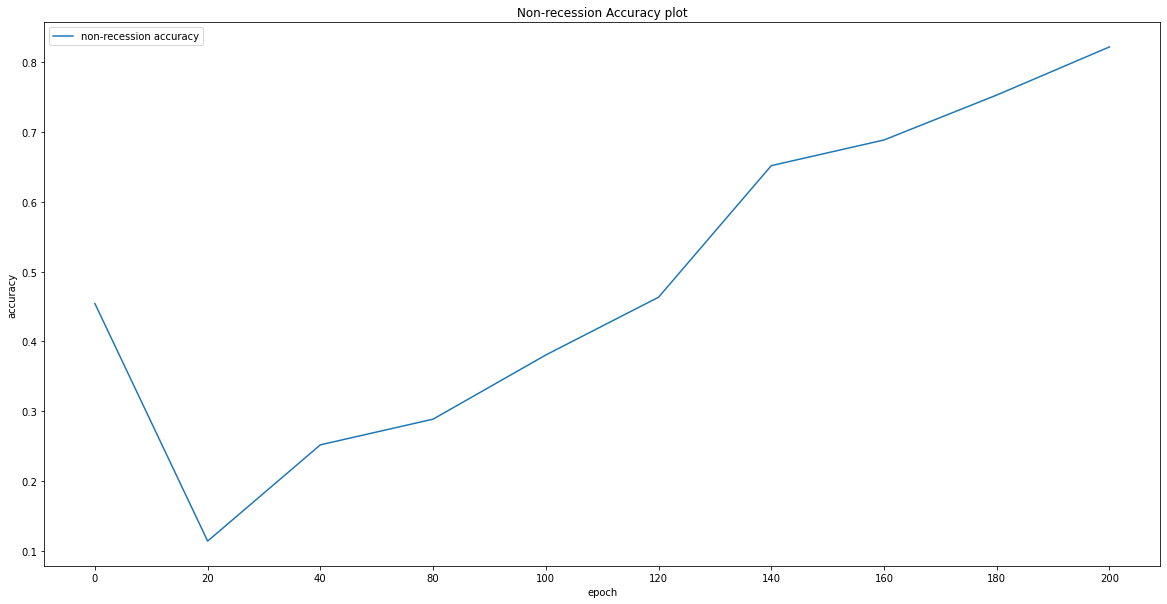

In [52]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(nr_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Non-recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['non-recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

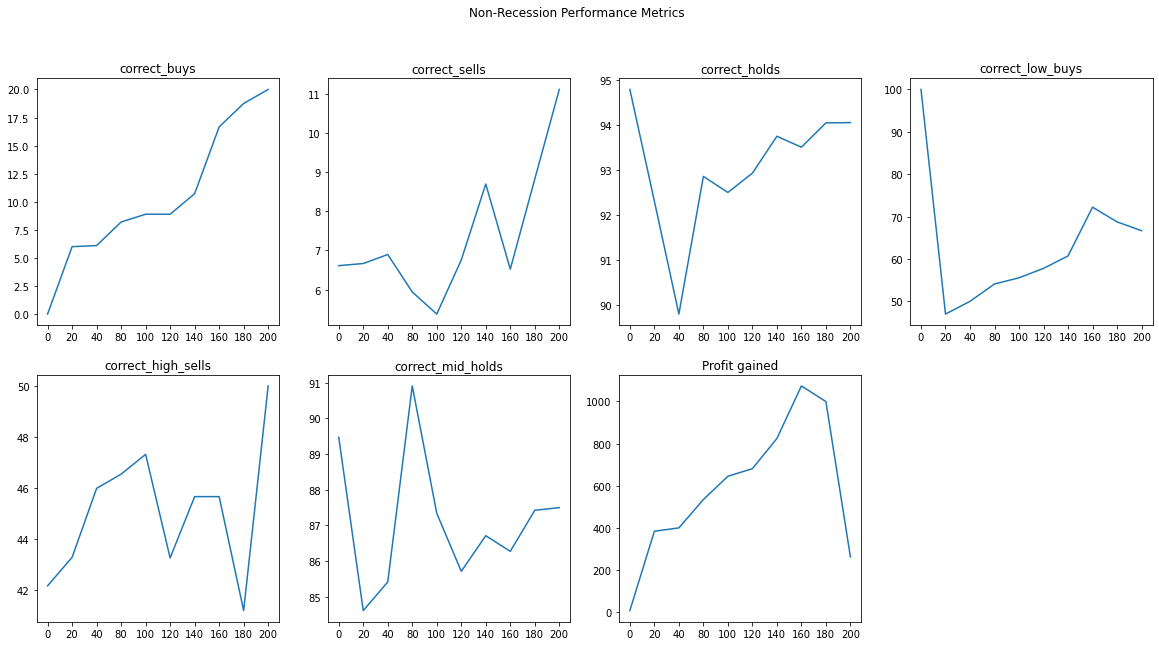

In [53]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(nr_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(nr_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(nr_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(nr_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(nr_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(nr_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(nr_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

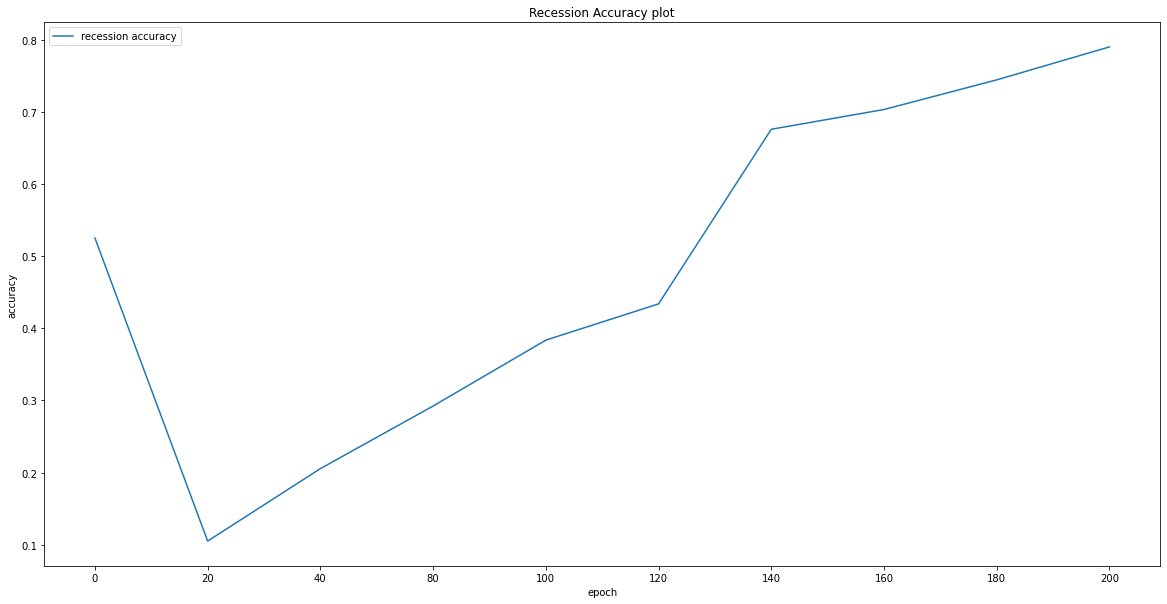

In [54]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(r_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

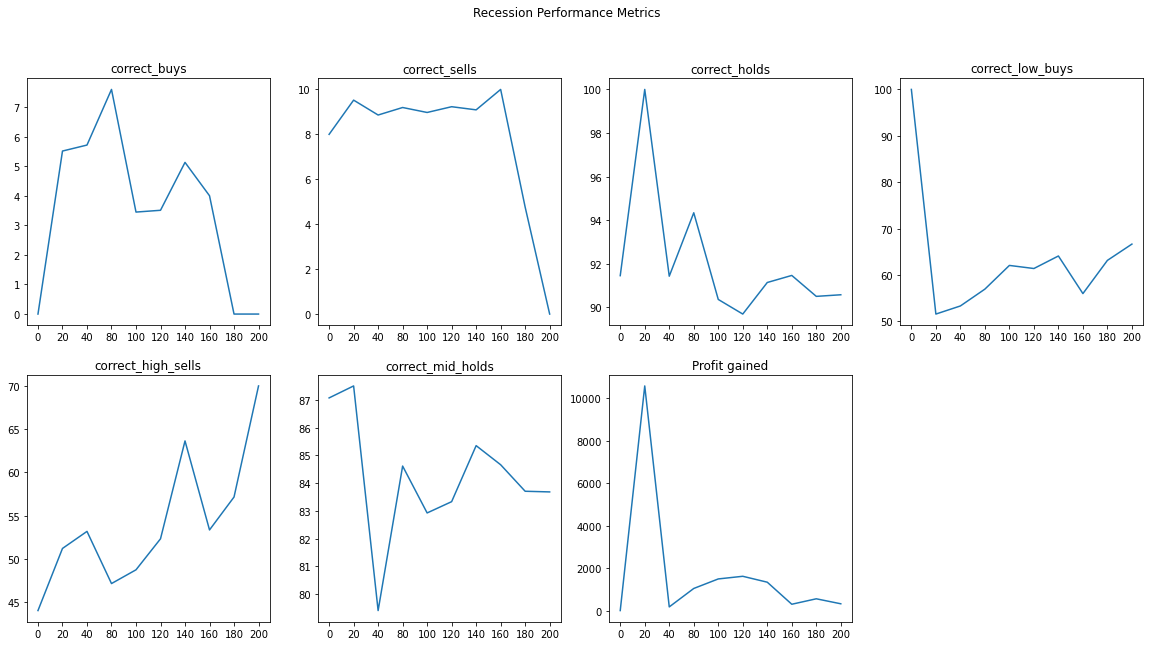

In [55]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(r_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(r_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(r_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(r_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(r_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(r_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(r_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

### Fresh Del Monte Produce Inc (small cap)

In [56]:
nr_test_sets = ['FDP']
nr_test_data = {}

for name in nr_test_sets:

    df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test.csv".format(name))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data.csv".format(name))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-5:]
    df2 = pd.concat([df2,df])
    df = df2
    print(df.head())
    
    willr_data = []
    price_data = []
    ema_data = []
    obv_data = []
    labels = []
    data_20_price = []
    data_20_willr = []
    data_20_ema = []
    data_20_obv = []
    count = 0

    for i in df.values:
        if count == 19:
            data_20_price.append([i[0]])
            data_20_ema.append([i[1]])
            data_20_willr.append([i[2]])
            data_20_obv.append([i[3]])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_20_price_arr = min_max_scaler.fit_transform(data_20_price)
            data_20_ema_arr = min_max_scaler.fit_transform(data_20_ema)
            data_20_willr_arr = min_max_scaler.fit_transform(data_20_willr)
            data_20_obv_arr = min_max_scaler.fit_transform(data_20_obv)
            price_data.append(data_20_price_arr)
            willr_data.append(data_20_willr_arr)
            ema_data.append(data_20_ema_arr)
            obv_data.append(data_20_obv_arr)
            labels.append(i[-1])
            data_20_price = data_20_price[1:]
            data_20_willr = data_20_willr[1:]
            data_20_obv = data_20_obv[1:]
            data_20_ema = data_20_ema[1:]

        else:
            data_20_price.append([i[0]])
            data_20_ema.append([i[1]])
            data_20_willr.append([i[2]])
            data_20_obv.append([i[3]])
            count += 1

    willr_data = np.array(willr_data)
    price_data = np.array(price_data)
    ema_data = np.array(ema_data)
    obv_data = np.array(obv_data)
    
    sequential_data = []
    
    for i in range(0,len(willr_data)):
        j = willr_data[i]
        k = price_data[i]
        l = ema_data[i]
        m = obv_data[i]
        fig, ax = plt.subplots()
        fig.set_size_inches((5,5))

        ax.plot(k)
        ax.plot(j)
        ax.plot(l)
        ax.plot(m)

        ax.axis('off')

        fig.add_axes(ax)
        fig.canvas.draw()

        # this rasterized the figure
        X = np.array(fig.canvas.renderer._renderer)
        X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
        X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
        sequential_data.append(X)
        plt.close()
        
    X = sequential_data
    y = labels

    X  = np.array(X).reshape(-1, 64, 64, 1)
    X = X/255
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    nr_test_data['{}_X'.format(name)] = X
    nr_test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2018-12-13    33.090000  32.210365 -29.500008  41799100.0     0.0
2018-12-14    33.310001  32.379540 -23.999977  42032900.0     2.0
2018-12-17    32.500000  32.398072 -44.923863  41904100.0     2.0
2018-12-18    32.150002  32.359908 -55.064902  41601100.0     2.0
2018-12-19    30.770000  32.115306 -94.085991  41369900.0     2.0


In [57]:
r_test_sets = ['FDP']
r_test_data = {}

for name in r_test_sets:

    df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test2.csv".format(name))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test.csv".format(name))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-5:]
    df2 = pd.concat([df2,df])
    df = df2
    print(df.head())
    
    willr_data = []
    price_data = []
    ema_data = []
    obv_data = []
    labels = []
    data_20_price = []
    data_20_willr = []
    data_20_ema = []
    data_20_obv = []
    count = 0

    for i in df.values:
        if count == 19:
            data_20_price.append([i[0]])
            data_20_ema.append([i[1]])
            data_20_willr.append([i[2]])
            data_20_obv.append([i[3]])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_20_price_arr = min_max_scaler.fit_transform(data_20_price)
            data_20_ema_arr = min_max_scaler.fit_transform(data_20_ema)
            data_20_willr_arr = min_max_scaler.fit_transform(data_20_willr)
            data_20_obv_arr = min_max_scaler.fit_transform(data_20_obv)
            price_data.append(data_20_price_arr)
            willr_data.append(data_20_willr_arr)
            ema_data.append(data_20_ema_arr)
            obv_data.append(data_20_obv_arr)
            labels.append(i[-1])
            data_20_price = data_20_price[1:]
            data_20_willr = data_20_willr[1:]
            data_20_obv = data_20_obv[1:]
            data_20_ema = data_20_ema[1:]

        else:
            data_20_price.append([i[0]])
            data_20_ema.append([i[1]])
            data_20_willr.append([i[2]])
            data_20_obv.append([i[3]])
            count += 1

    willr_data = np.array(willr_data)
    price_data = np.array(price_data)
    ema_data = np.array(ema_data)
    obv_data = np.array(obv_data)
    
    sequential_data = []
    
    for i in range(0,len(willr_data)):
        j = willr_data[i]
        k = price_data[i]
        l = ema_data[i]
        m = obv_data[i]
        fig, ax = plt.subplots()
        fig.set_size_inches((5,5))

        ax.plot(k)
        ax.plot(j)
        ax.plot(l)
        ax.plot(m)

        ax.axis('off')

        fig.add_axes(ax)
        fig.canvas.draw()

        # this rasterized the figure
        X = np.array(fig.canvas.renderer._renderer)
        X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
        X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
        sequential_data.append(X)
        plt.close()
        
    X = sequential_data
    y = labels

    X  = np.array(X).reshape(-1, 64, 64, 1)
    X = X/255
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    r_test_data['{}_X'.format(name)] = X
    r_test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14      OBV_7  labels
Date                                                            
2019-12-13    34.299999  33.185402  -7.909676 -4911100.0     2.0
2019-12-16    33.759998  33.273801 -23.163935 -5027000.0     2.0
2019-12-17    34.160000  33.410139 -15.789538 -4850100.0     2.0
2019-12-18    34.669998  33.603964  -3.968344 -4647200.0     2.0
2019-12-19    34.470001  33.737200 -18.420973 -4830200.0     2.0


### Training Data

            previous_1d    EMA_12   willr_14     OBV_7  labels
Date                                                          
2000-01-21       8.7500  8.946622 -66.666667   78200.0     2.0
2000-01-24       8.8750  8.935603 -58.333333   99900.0     2.0
2000-01-25       9.0000  8.945511 -50.000000  123600.0     2.0
2000-01-26       8.6875  8.905817 -70.833333   87300.0     2.0
2000-01-27       8.5625  8.852999 -76.000000   32400.0     2.0


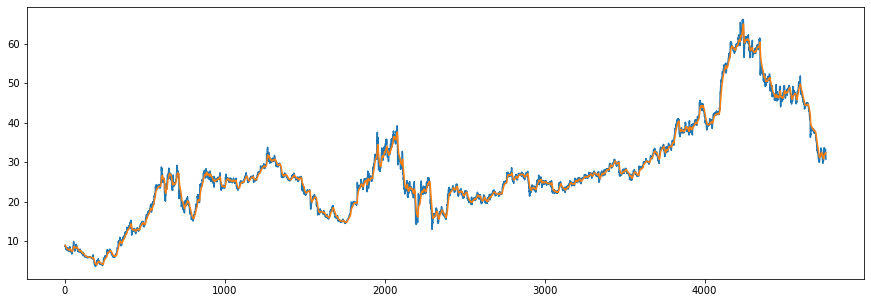

(4740, 64, 64, 1)

In [58]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []

seed = 10
df = pd.read_csv('data/noncyclic_tickers/initial_indicators/FDP_data.csv')
df.set_index('Date', inplace=True)
print(df.head())

plt.figure(figsize=(15,5))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
plt.show()

data_20_price = []
data_20_willr = []
data_20_ema = []
data_20_obv = []
count = 0

for i in df.values:
    if count == 19:
        data_20_price.append([i[0]])
        data_20_ema.append([i[1]])
        data_20_willr.append([i[2]])
        data_20_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_20_price_arr = min_max_scaler.fit_transform(data_20_price)
        data_20_ema_arr = min_max_scaler.fit_transform(data_20_ema)
        data_20_willr_arr = min_max_scaler.fit_transform(data_20_willr)
        data_20_obv_arr = min_max_scaler.fit_transform(data_20_obv)
        price_data.append(data_20_price_arr)
        willr_data.append(data_20_willr_arr)
        ema_data.append(data_20_ema_arr)
        obv_data.append(data_20_obv_arr)
        labels.append(i[-1])
        data_20_price = data_20_price[1:]
        data_20_willr = data_20_willr[1:]
        data_20_obv = data_20_obv[1:]
        data_20_ema = data_20_ema[1:]

    else:
        data_20_price.append([i[0]])
        data_20_ema.append([i[1]])
        data_20_willr.append([i[2]])
        data_20_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()
    
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

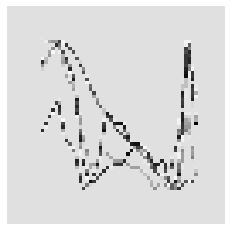

In [59]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [60]:
X = X/255

In [61]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [62]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [63]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [64]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.25, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [65]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

epochs = 0 
histories = {}
nr_log_hist = {}
r_log_hist = {}
column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
nr_log  = pd.DataFrame(columns = column_names)
r_log  = pd.DataFrame(columns = column_names)

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    print('\n')
    print('Non-Recession Test')
    print('\n')
        
    X = nr_test_data['{}_X'.format('FDP')]
    y = nr_test_data['{}_y'.format('FDP')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test.csv".format('FDP'))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data.csv".format('FDP'))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-5:]
    df2 = pd.concat([df2,df])
    df = df2.iloc[19:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    nr_length = len(nr_log)
    log.loc[df_length] = logger
    nr_log.loc[nr_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_non_recession.csv'.format(experiment,'FDP')):
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'FDP'))
    else:
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'FDP'), mode='a', header=False)
    
    
    print('\n')
    print('Recession Test')
    print('\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    log  = pd.DataFrame(columns = column_names)
    logger = []
        
    X = r_test_data['{}_X'.format('FDP')]
    y = r_test_data['{}_y'.format('FDP')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test2.csv".format('FDP'))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test.csv".format('FDP'))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-5:]
    df2 = pd.concat([df2,df])
    df = df2.iloc[19:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    r_length = len(r_log)
    log.loc[df_length] = logger
    r_log.loc[r_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_recession.csv'.format(experiment,'FDP')):
        log.to_csv('{}_{}_recession.csv'.format(experiment,'FDP'))
    else:
        log.to_csv('{}_{}_recession.csv'.format(experiment,'FDP'), mode='a', header=False)
    
    epochs = epochs + 20
    
nr_log_hist['epochs_logs'] = nr_log
r_log_hist['epochs_logs'] = r_log

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 0 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.30635838150289, 1: 7.181818181818182, 2: 0.36712169619517865}



RUNNING EPOCHS 0 - 20



Epoch 1/20
30/30 [==============================] - 1s 18ms/step - loss: 0.2471 - accuracy: 0.4607 - mse: 1.5113 - weighted_accuracy: 0.3407 - weighted_mse: 1.6242 - val_loss: 0.1869 - val_accuracy: 0.7373 - val_mse: 0.8888 - val_weighted_accuracy: 0.7373 - val_weighted_mse: 0.8888
Epoch 2/20
30/30 [==============================] - 0s 10ms/step - loss: 0.2038 - accuracy: 0.4586 - mse: 1.1500 - weighted_accuracy: 0.3598 - weighted_mse: 1.1759 - val_loss: 0.1992 - val_accuracy: 0.3914 - val_mse: 0.8999 - val_weighted_accuracy: 0.3914 - val_weighted_mse: 0.8999
Epoch 3/20
30/30 [==============================] - 0s 11ms/step - loss: 0.2056 - accuracy: 0.4119 - mse: 1.1699 - weighted_accuracy: 0.2941 - weighted_mse: 1.1763 - val_loss: 0.1952 - val_accuracy: 0.6920 - val_mse: 0.9131 - val_weighted_accuracy: 0.6920 - val_weighted_mse: 0.9131
Epoch 4/20
30/30 [==============================] - 0s 

7/7 [==============================] - 0s 3ms/step - loss: 0.1883 - accuracy: 0.9087 - mse: 0.9706 - weighted_accuracy: 0.9087 - weighted_mse: 0.9706
Test loss: 0.18833810091018677
Test accuracy: 0.9086757898330688


number of predictions: 219
actual predicted buys: 0
actual buys but predicted sell: 0
actual buys but predicted hold: 10
actual sells but predicted buy: 0
actual predicted sells: 0
actual sells but predicted hold: 10
actual holds but predicted buy: 0
actual holds but predicted sell: 0
actual predicted holds: 199
Percentage buys correct: 0%
Percentage sells correct: 0%
Percentage holds correct: 90.8675799086758%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 0%
Percentage high sells correct: 0%
Percentage mid holds correct: 82.56880733944953%


Capital: 100


Capital at the end of test period: $100
profit gained: 0.0%


Capital at the end of test period if Buy and Hold: $34.02868734789972
profit gained: -65.97131265210028%
   Test_accuracy

<ipython-input-65-8782b739b89e>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-65-8782b739b89e>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-65-8782b739b89e>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Epoch 1/20
30/30 [==============================] - 0s 13ms/step - loss: 0.2023 - accuracy: 0.3763 - mse: 1.1792 - weighted_accuracy: 0.3338 - weighted_mse: 1.1763 - val_loss: 0.2004 - val_accuracy: 0.1287 - val_mse: 0.8973 - val_weighted_accuracy: 0.1287 - val_weighted_mse: 0.8973
Epoch 2/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1991 - accuracy: 0.3405 - mse: 1.1723 - weighted_accuracy: 0.3501 - weighted_mse: 1.1714 - val_loss: 0.1965 - val_accuracy: 0.2700 - val_mse: 0.9257 - val_weighted_accuracy: 0.2700 - val_weighted_mse: 0.9257
Epoch 3/20
30/30 [==============================] - 0s 11ms/step - loss: 0.2002 - accuracy: 0.3463 - mse: 1.1891 - weighted_accuracy: 0.3229 - weighted_mse: 1.1729 - val_loss: 0.1910 - val_accuracy: 0.0538 - val_mse: 0.9724 - val_weighted_accuracy: 0.0538 - val_weighted_mse: 0.9724
Epoch 4/20
30/30 [==============================] - 0s 11ms/step - loss: 0.1998 - accuracy: 0.3681 - mse: 1.1788 - weighted_accuracy: 0.3546 - weighted

7/7 [==============================] - 0s 3ms/step - loss: 0.1924 - accuracy: 0.3105 - mse: 0.9669 - weighted_accuracy: 0.3105 - weighted_mse: 0.9669
Test loss: 0.19235830008983612
Test accuracy: 0.310502290725708


number of predictions: 219
actual predicted buys: 7
actual buys but predicted sell: 1
actual buys but predicted hold: 2
actual sells but predicted buy: 5
actual predicted sells: 3
actual sells but predicted hold: 2
actual holds but predicted buy: 79
actual holds but predicted sell: 62
actual predicted holds: 58
Percentage buys correct: 7.6923076923076925%
Percentage sells correct: 4.545454545454546%
Percentage holds correct: 93.54838709677419%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 50.0%
Percentage high sells correct: 45.45454545454545%
Percentage mid holds correct: 88.70967741935483%


Capital: 100
Share price: $0.8375646130956491
Shares owned at the moment: 119
Cash capital at the moment: $0.05571802198220155


Price increase fro

<ipython-input-65-8782b739b89e>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-65-8782b739b89e>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-65-8782b739b89e>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu





RUNNING EPOCHS 40 - 60



Epoch 1/20
30/30 [==============================] - 0s 16ms/step - loss: 0.1951 - accuracy: 0.3510 - mse: 1.1838 - weighted_accuracy: 0.3828 - weighted_mse: 1.1752 - val_loss: 0.1932 - val_accuracy: 0.3196 - val_mse: 0.9756 - val_weighted_accuracy: 0.3196 - val_weighted_mse: 0.9756
Epoch 2/20
30/30 [==============================] - 0s 14ms/step - loss: 0.1939 - accuracy: 0.3354 - mse: 1.1639 - weighted_accuracy: 0.4094 - weighted_mse: 1.1693 - val_loss: 0.1938 - val_accuracy: 0.2025 - val_mse: 1.0042 - val_weighted_accuracy: 0.2025 - val_weighted_mse: 1.0042
Epoch 3/20
30/30 [==============================] - 0s 15ms/step - loss: 0.1957 - accuracy: 0.3536 - mse: 1.1812 - weighted_accuracy: 0.3712 - weighted_mse: 1.1772 - val_loss: 0.1870 - val_accuracy: 0.5211 - val_mse: 1.0314 - val_weighted_accuracy: 0.5211 - val_weighted_mse: 1.0314
Epoch 4/20
30/30 [==============================] - 0s 14ms/step - loss: 0.1958 - accuracy: 0.3473 - mse: 1.2137 - weight

7/7 [==============================] - 0s 3ms/step - loss: 0.1858 - accuracy: 0.3790 - mse: 1.0698 - weighted_accuracy: 0.3790 - weighted_mse: 1.0698
Test loss: 0.18576595187187195
Test accuracy: 0.37899544835090637


number of predictions: 219
actual predicted buys: 8
actual buys but predicted sell: 1
actual buys but predicted hold: 1
actual sells but predicted buy: 5
actual predicted sells: 3
actual sells but predicted hold: 2
actual holds but predicted buy: 88
actual holds but predicted sell: 39
actual predicted holds: 72
Percentage buys correct: 7.920792079207921%
Percentage sells correct: 6.976744186046512%
Percentage holds correct: 96.0%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 52.0%
Percentage high sells correct: 44.18604651162791%
Percentage mid holds correct: 84.0%


Capital: 100
Share price: $0.8375646130956491
Shares owned at the moment: 119
Cash capital at the moment: $0.05571802198220155


Price increase from previously bought: 3.84

<ipython-input-65-8782b739b89e>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-65-8782b739b89e>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-65-8782b739b89e>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Epoch 1/20
30/30 [==============================] - 0s 14ms/step - loss: 0.1857 - accuracy: 0.2729 - mse: 1.2132 - weighted_accuracy: 0.4645 - weighted_mse: 1.1927 - val_loss: 0.1905 - val_accuracy: 0.2205 - val_mse: 1.0779 - val_weighted_accuracy: 0.2205 - val_weighted_mse: 1.0779
Epoch 2/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1837 - accuracy: 0.2835 - mse: 1.2367 - weighted_accuracy: 0.4959 - weighted_mse: 1.2159 - val_loss: 0.1928 - val_accuracy: 0.1276 - val_mse: 1.0583 - val_weighted_accuracy: 0.1276 - val_weighted_mse: 1.0583
Epoch 3/20
30/30 [==============================] - 0s 11ms/step - loss: 0.1857 - accuracy: 0.2906 - mse: 1.2103 - weighted_accuracy: 0.4770 - weighted_mse: 1.1825 - val_loss: 0.1882 - val_accuracy: 0.2405 - val_mse: 1.0519 - val_weighted_accuracy: 0.2405 - val_weighted_mse: 1.0519
Epoch 4/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1833 - accuracy: 0.3099 - mse: 1.2258 - weighted_accuracy: 0.5019 - weighted

7/7 [==============================] - 0s 3ms/step - loss: 0.1855 - accuracy: 0.3196 - mse: 1.1380 - weighted_accuracy: 0.3196 - weighted_mse: 1.1380
Test loss: 0.18552513420581818
Test accuracy: 0.31963470578193665




<ipython-input-65-8782b739b89e>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-65-8782b739b89e>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-65-8782b739b89e>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

number of predictions: 219
actual predicted buys: 8
actual buys but predicted sell: 1
actual buys but predicted hold: 1
actual sells but predicted buy: 4
actual predicted sells: 5
actual sells but predicted hold: 1
actual holds but predicted buy: 87
actual holds but predicted sell: 55
actual predicted holds: 57
Percentage buys correct: 8.080808080808081%
Percentage sells correct: 8.19672131147541%
Percentage holds correct: 96.61016949152543%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 54.08163265306123%
Percentage high sells correct: 50.81967213114754%
Percentage mid holds correct: 88.13559322033899%


Capital: 100
Share price: $0.8375646130956491
Shares owned at the moment: 119
Cash capital at the moment: $0.05571802198220155


Price increase from previously bought: 3.3224689921353967%
Share price: $0.8677722668584018
Shares owned at the moment: 0
Cash capital at the moment: $103.0366393038026


Share price: $0.6128949931790368
Shares owned at the

Epoch 10/20
30/30 [==============================] - 0s 11ms/step - loss: 0.1567 - accuracy: 0.2848 - mse: 1.4370 - weighted_accuracy: 0.5960 - weighted_mse: 1.4029 - val_loss: 0.1868 - val_accuracy: 0.2711 - val_mse: 1.2156 - val_weighted_accuracy: 0.2711 - val_weighted_mse: 1.2156
Epoch 11/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1558 - accuracy: 0.3117 - mse: 1.3742 - weighted_accuracy: 0.6060 - weighted_mse: 1.3575 - val_loss: 0.1804 - val_accuracy: 0.3660 - val_mse: 1.2593 - val_weighted_accuracy: 0.3660 - val_weighted_mse: 1.2593
Epoch 12/20
30/30 [==============================] - 0s 11ms/step - loss: 0.1541 - accuracy: 0.3080 - mse: 1.3988 - weighted_accuracy: 0.6373 - weighted_mse: 1.3693 - val_loss: 0.1954 - val_accuracy: 0.2289 - val_mse: 1.2443 - val_weighted_accuracy: 0.2289 - val_weighted_mse: 1.2443
Epoch 13/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1542 - accuracy: 0.3318 - mse: 1.4137 - weighted_accuracy: 0.6278 - weig

7/7 [==============================] - 0s 3ms/step - loss: 0.1804 - accuracy: 0.3653 - mse: 1.2795 - weighted_accuracy: 0.3653 - weighted_mse: 1.2795
Test loss: 0.18039435148239136
Test accuracy: 0.3652968108654022




<ipython-input-65-8782b739b89e>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-65-8782b739b89e>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-65-8782b739b89e>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

number of predictions: 219
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 4
actual predicted sells: 4
actual sells but predicted hold: 2
actual holds but predicted buy: 93
actual holds but predicted sell: 38
actual predicted holds: 68
Percentage buys correct: 7.619047619047619%
Percentage sells correct: 9.523809523809524%
Percentage holds correct: 94.44444444444444%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 54.80769230769231%
Percentage high sells correct: 50.0%
Percentage mid holds correct: 80.55555555555556%


Capital: 100
Share price: $0.8375646130956491
Shares owned at the moment: 119
Cash capital at the moment: $0.05571802198220155


Price increase from previously bought: 2.0486450003247336%
Share price: $0.8570738278476548
Shares owned at the moment: 0
Cash capital at the moment: $101.76702612568998


Share price: $0.6128949931790368
Shares owned at the moment: 16

<ipython-input-65-8782b739b89e>:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


30/30 [==============================] - 0s 13ms/step - loss: 0.1482 - accuracy: 0.3584 - mse: 1.4391 - weighted_accuracy: 0.6573 - weighted_mse: 1.4242 - val_loss: 0.1826 - val_accuracy: 0.3776 - val_mse: 1.3582 - val_weighted_accuracy: 0.3776 - val_weighted_mse: 1.3582
Epoch 2/20
30/30 [==============================] - 0s 11ms/step - loss: 0.1445 - accuracy: 0.3729 - mse: 1.5241 - weighted_accuracy: 0.6664 - weighted_mse: 1.5036 - val_loss: 0.1839 - val_accuracy: 0.3492 - val_mse: 1.2999 - val_weighted_accuracy: 0.3492 - val_weighted_mse: 1.2999
Epoch 3/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1427 - accuracy: 0.3473 - mse: 1.5106 - weighted_accuracy: 0.6499 - weighted_mse: 1.5070 - val_loss: 0.1818 - val_accuracy: 0.3671 - val_mse: 1.3288 - val_weighted_accuracy: 0.3671 - val_weighted_mse: 1.3288
Epoch 4/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1419 - accuracy: 0.3687 - mse: 1.4841 - weighted_accuracy: 0.6705 - weighted_mse: 1.478

7/7 [==============================] - 0s 2ms/step - loss: 0.1678 - accuracy: 0.5205 - mse: 1.4257 - weighted_accuracy: 0.5205 - weighted_mse: 1.4257
Test loss: 0.16780681908130646
Test accuracy: 0.5205479264259338


number of predictions: 219
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 3
actual sells but predicted buy: 4
actual predicted sells: 4
actual sells but predicted hold: 2
actual holds but predicted buy: 62
actual holds but predicted sell: 34
actual predicted holds: 103
Percentage buys correct: 9.58904109589041%
Percentage sells correct: 10.526315789473685%
Percentage holds correct: 95.37037037037037%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 58.9041095890411%
Percentage high sells correct: 52.63157894736842%
Percentage mid holds correct: 84.11214953271028%


Capital: 100
Share price: $0.6128949931790368
Shares owned at the moment: 162
Cash capital at the moment: $0.4379663855347644


Price 

<ipython-input-65-8782b739b89e>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-65-8782b739b89e>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-65-8782b739b89e>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Epoch 1/20
30/30 [==============================] - 0s 13ms/step - loss: 0.1283 - accuracy: 0.4697 - mse: 1.6453 - weighted_accuracy: 0.7145 - weighted_mse: 1.7349 - val_loss: 0.1683 - val_accuracy: 0.5211 - val_mse: 1.4536 - val_weighted_accuracy: 0.5211 - val_weighted_mse: 1.4536
Epoch 2/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1314 - accuracy: 0.4628 - mse: 1.6503 - weighted_accuracy: 0.7048 - weighted_mse: 1.7204 - val_loss: 0.1880 - val_accuracy: 0.3797 - val_mse: 1.4457 - val_weighted_accuracy: 0.3797 - val_weighted_mse: 1.4457
Epoch 3/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1276 - accuracy: 0.4644 - mse: 1.6529 - weighted_accuracy: 0.7232 - weighted_mse: 1.7620 - val_loss: 0.1614 - val_accuracy: 0.5686 - val_mse: 1.4619 - val_weighted_accuracy: 0.5686 - val_weighted_mse: 1.4619
Epoch 4/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1294 - accuracy: 0.4607 - mse: 1.6900 - weighted_accuracy: 0.7110 - weighted

7/7 [==============================] - 0s 3ms/step - loss: 0.1486 - accuracy: 0.6667 - mse: 1.5424 - weighted_accuracy: 0.6667 - weighted_mse: 1.5424
Test loss: 0.1485767513513565
Test accuracy: 0.6666666865348816




<ipython-input-65-8782b739b89e>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-65-8782b739b89e>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-65-8782b739b89e>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

number of predictions: 219
actual predicted buys: 5
actual buys but predicted sell: 0
actual buys but predicted hold: 5
actual sells but predicted buy: 4
actual predicted sells: 3
actual sells but predicted hold: 3
actual holds but predicted buy: 41
actual holds but predicted sell: 20
actual predicted holds: 138
Percentage buys correct: 10.0%
Percentage sells correct: 13.043478260869565%
Percentage holds correct: 94.52054794520548%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 60.0%
Percentage high sells correct: 52.17391304347826%
Percentage mid holds correct: 83.44827586206897%


Capital: 100
Share price: $0.6128949931790368
Shares owned at the moment: 162
Cash capital at the moment: $0.4379663855347644


Price increase from previously bought: 13.447275826832739%
Share price: $0.6972247832926315
Shares owned at the moment: 0
Cash capital at the moment: $113.0777676379842


Share price: $0.3806733998044638
Shares owned at the moment: 296
Cash capita

30/30 [==============================] - 0s 11ms/step - loss: 0.1054 - accuracy: 0.6007 - mse: 2.0314 - weighted_accuracy: 0.7769 - weighted_mse: 2.3683 - val_loss: 0.1386 - val_accuracy: 0.7046 - val_mse: 1.8375 - val_weighted_accuracy: 0.7046 - val_weighted_mse: 1.8375
Epoch 16/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1077 - accuracy: 0.6031 - mse: 2.1797 - weighted_accuracy: 0.7833 - weighted_mse: 2.4824 - val_loss: 0.1440 - val_accuracy: 0.6698 - val_mse: 1.6648 - val_weighted_accuracy: 0.6698 - val_weighted_mse: 1.6648
Epoch 17/20
30/30 [==============================] - 0s 11ms/step - loss: 0.1063 - accuracy: 0.6018 - mse: 2.1623 - weighted_accuracy: 0.7790 - weighted_mse: 2.4372 - val_loss: 0.1389 - val_accuracy: 0.6878 - val_mse: 1.7736 - val_weighted_accuracy: 0.6878 - val_weighted_mse: 1.7736
Epoch 18/20
30/30 [==============================] - 0s 11ms/step - loss: 0.1070 - accuracy: 0.6031 - mse: 2.0874 - weighted_accuracy: 0.7758 - weighted_mse: 2.

<ipython-input-65-8782b739b89e>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-65-8782b739b89e>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-65-8782b739b89e>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu


Shares owned at the moment: 197
Cash capital at the moment: $0.06177124403052403


Price increase from previously bought: 37.43817958194906%
Share price: $0.6972247832926315
Shares owned at the moment: 0
Cash capital at the moment: $137.03733202633015


Share price: $0.2938263652279127
Shares owned at the moment: 465
Cash capital at the moment: $0.03234173081554559


Price increase from previously bought: -29.109688927511545%
Share price: $0.20886723398994178
Shares owned at the moment: 0
Cash capital at the moment: $96.88851656067382


Share price: $0.05845806623146154
Shares owned at the moment: 1652
Cash capital at the moment: $0.0502161514098276


Price increase from previously bought: 247.7255333123268%
Share price: $0.2038326250294833
Shares owned at the moment: 0
Cash capital at the moment: $335.85570108460723


Share price: $0.19376340710856566
Shares owned at the moment: 1728
Cash capital at the moment: $0.11176989042587593


Price increase from previously bought: 2.640864424

Epoch 18/20
30/30 [==============================] - 0s 11ms/step - loss: 0.0949 - accuracy: 0.6508 - mse: 2.4757 - weighted_accuracy: 0.8097 - weighted_mse: 2.9806 - val_loss: 0.1261 - val_accuracy: 0.7468 - val_mse: 1.9706 - val_weighted_accuracy: 0.7468 - val_weighted_mse: 1.9706
Epoch 19/20
30/30 [==============================] - 0s 12ms/step - loss: 0.0980 - accuracy: 0.6382 - mse: 2.5400 - weighted_accuracy: 0.7869 - weighted_mse: 3.0194 - val_loss: 0.1161 - val_accuracy: 0.7985 - val_mse: 1.9127 - val_weighted_accuracy: 0.7985 - val_weighted_mse: 1.9127
Epoch 20/20
30/30 [==============================] - 0s 11ms/step - loss: 0.0935 - accuracy: 0.6566 - mse: 2.4422 - weighted_accuracy: 0.8101 - weighted_mse: 3.0224 - val_loss: 0.1136 - val_accuracy: 0.8059 - val_mse: 1.9276 - val_weighted_accuracy: 0.8059 - val_weighted_mse: 1.9276
Validation loss: 0.11355497688055038
Validation accuracy: 0.8059071898460388


Non-Recession Test


7/7 [==============================] - 0s 3ms/st

<ipython-input-65-8782b739b89e>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-65-8782b739b89e>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-65-8782b739b89e>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Epoch 1/20
30/30 [==============================] - 0s 13ms/step - loss: 0.0974 - accuracy: 0.6516 - mse: 2.5776 - weighted_accuracy: 0.7972 - weighted_mse: 3.0136 - val_loss: 0.1152 - val_accuracy: 0.7911 - val_mse: 2.0195 - val_weighted_accuracy: 0.7911 - val_weighted_mse: 2.0195
Epoch 2/20
30/30 [==============================] - 0s 12ms/step - loss: 0.0937 - accuracy: 0.6472 - mse: 2.4386 - weighted_accuracy: 0.8085 - weighted_mse: 3.0483 - val_loss: 0.1187 - val_accuracy: 0.7859 - val_mse: 1.9942 - val_weighted_accuracy: 0.7859 - val_weighted_mse: 1.9942
Epoch 3/20
30/30 [==============================] - 0s 11ms/step - loss: 0.0928 - accuracy: 0.6580 - mse: 2.5833 - weighted_accuracy: 0.8088 - weighted_mse: 3.1267 - val_loss: 0.1162 - val_accuracy: 0.7954 - val_mse: 1.9568 - val_weighted_accuracy: 0.7954 - val_weighted_mse: 1.9568
Epoch 4/20
30/30 [==============================] - 0s 11ms/step - loss: 0.0938 - accuracy: 0.6569 - mse: 2.6036 - weighted_accuracy: 0.7901 - weighted

7/7 [==============================] - 0s 3ms/step - loss: 0.1040 - accuracy: 0.8265 - mse: 2.1846 - weighted_accuracy: 0.8265 - weighted_mse: 2.1846
Test loss: 0.10397344082593918
Test accuracy: 0.8264840245246887


number of predictions: 219
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 8
actual holds but predicted buy: 13
actual holds but predicted sell: 9
actual predicted holds: 177
Percentage buys correct: 13.333333333333334%
Percentage sells correct: 18.181818181818183%
Percentage holds correct: 91.70984455958549%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 73.33333333333333%
Percentage high sells correct: 63.63636363636363%
Percentage mid holds correct: 82.8125%


Capital: 100
Share price: $0.5059094027261046
Shares owned at the moment: 197
Cash capital at the moment: $0.06177124403052403


Price increas

<ipython-input-65-8782b739b89e>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-65-8782b739b89e>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-65-8782b739b89e>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

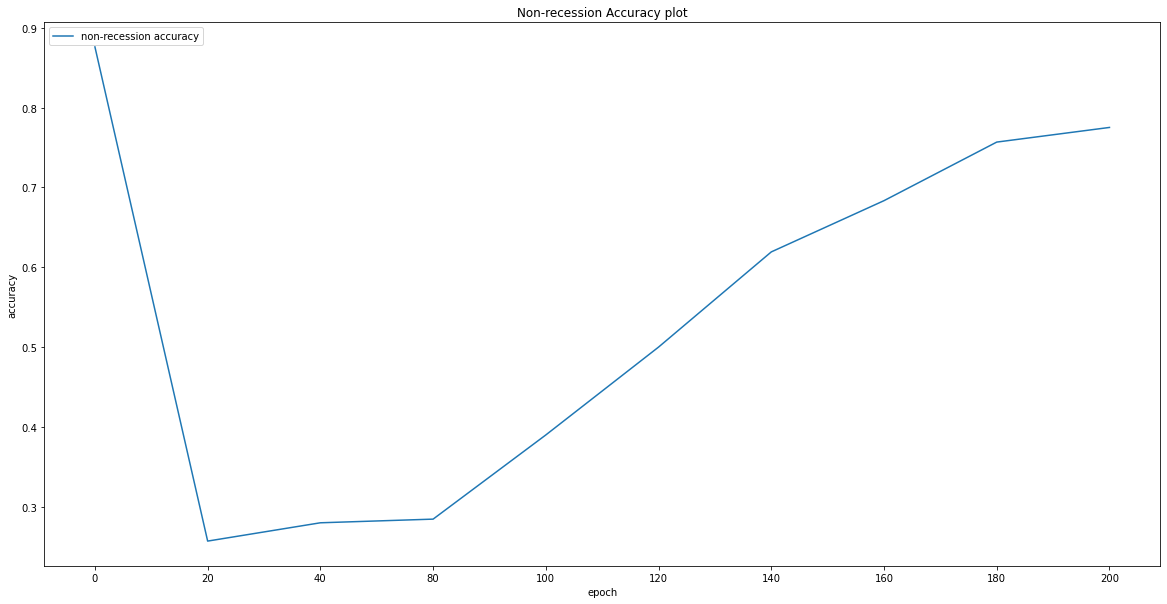

In [66]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(nr_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Non-recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['non-recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

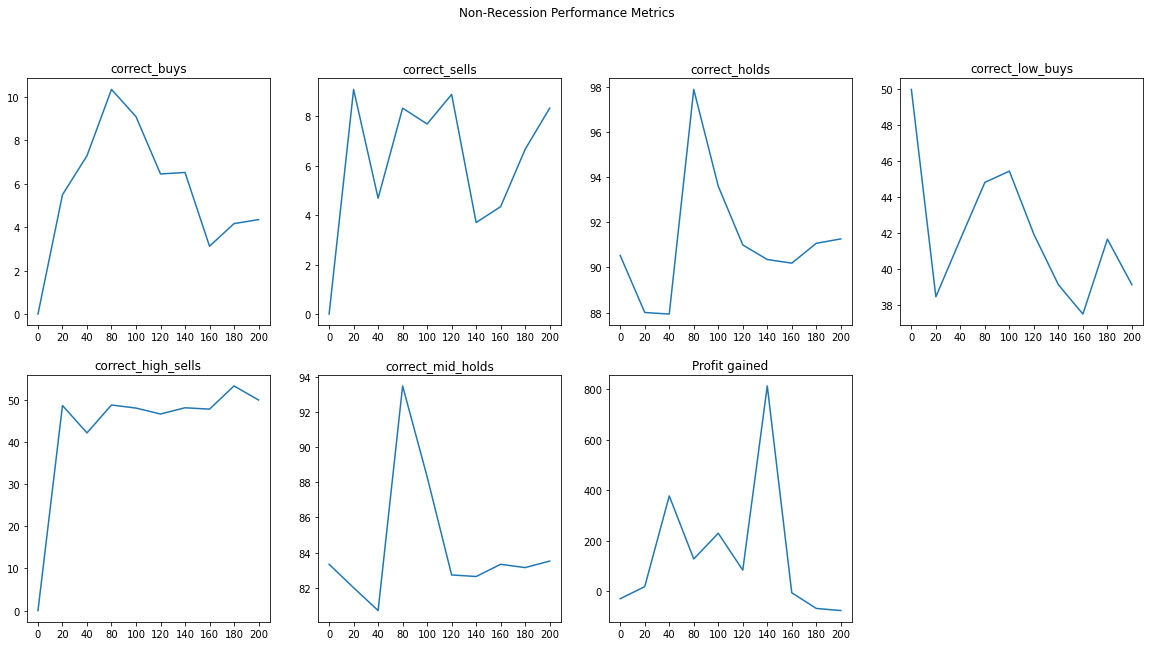

In [67]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(nr_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(nr_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(nr_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(nr_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(nr_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(nr_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(nr_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

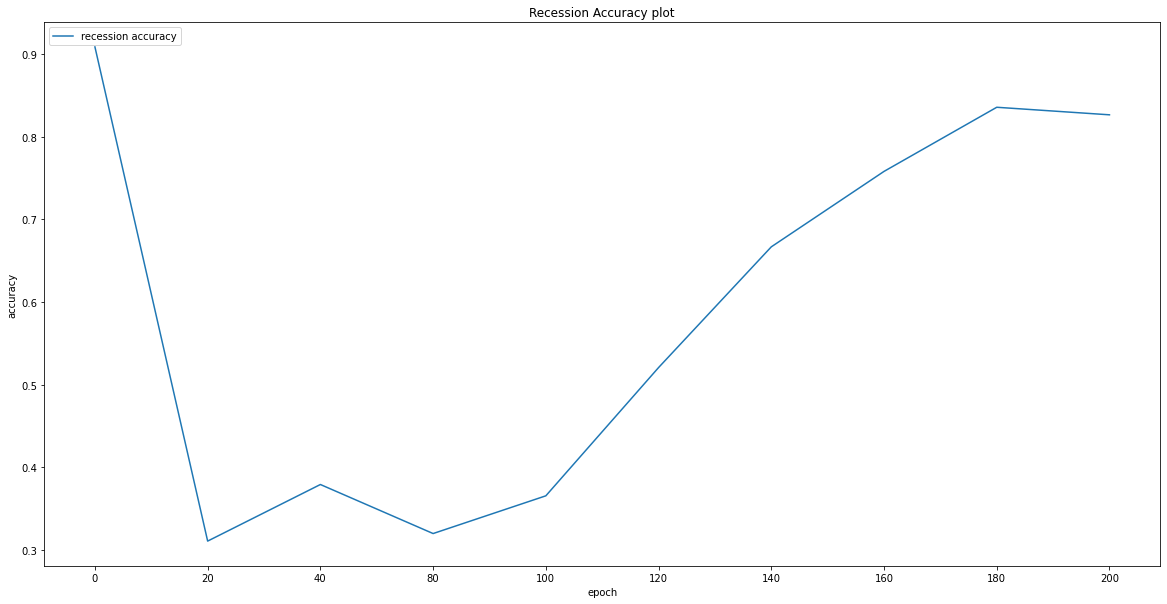

In [68]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(r_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

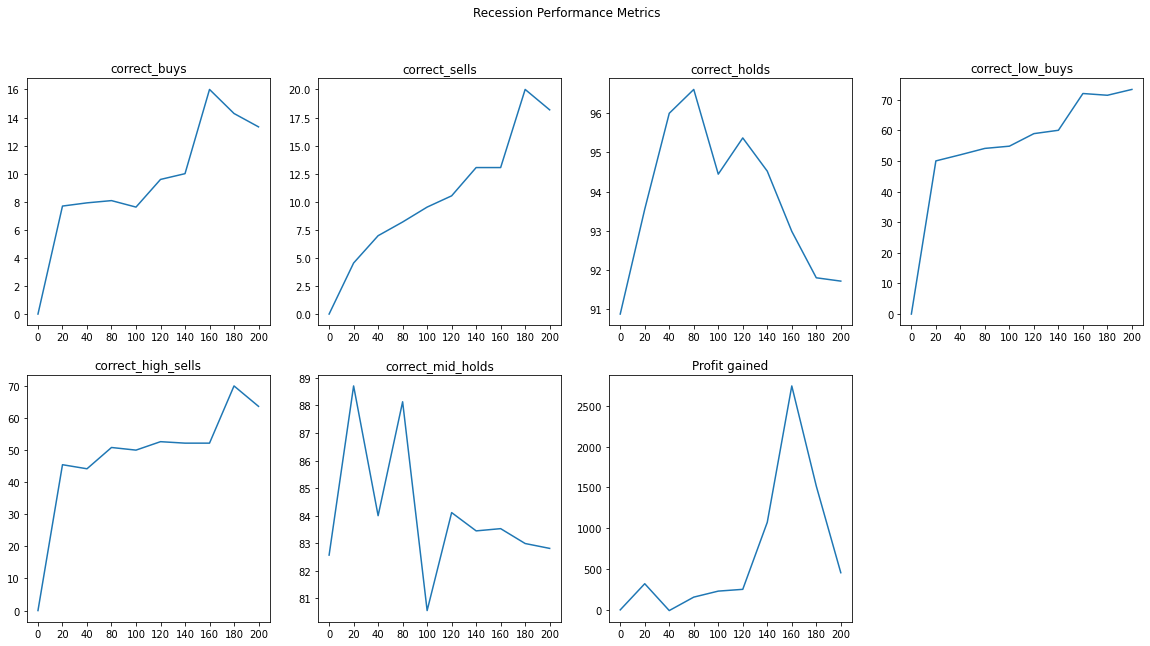

In [69]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(r_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(r_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(r_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(r_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(r_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(r_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(r_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")